Code tied to this paper: Milia, M. F. (2025, September 3). Epistemic Diversity in other-than-English Contexts: The Role of Open Publishing in Latin America’s Scientific Landscape. 4S 2025 - Reverberations, Seattle.


# Building a Corpus

**Purpose:** Analyze keyword co-occurrence patterns in a TSV dataset to identify disciplinary relationships and thematic clustering among predefined target keywords.

**Input File:** 
- `OJS-LatAm-Installations-OJSinDOAJ.tsv` - Dataset with keyword information

**Target Keywords:**
14 disciplinary terms: social sciences, education, history, humanities, literature, law, sociology, engineering, philosophy, linguistics, economics, latin america, anthropology, medicine

**Analysis Components:**
1. **Individual frequency counts** for each target keyword
2. **Pairwise co-occurrence** between target keywords within observations
3. **Associated keywords discovery** for each target (non-target keywords that frequently co-occur)
4. **Co-occurrence matrix** showing all target keyword relationships
5. **Distribution analysis** of target keywords per observation

**Visualization Outputs:**
- Bar charts of individual keyword frequencies
- Heatmap of co-occurrence matrix between targets
- Histogram of target keywords per observation
- Horizontal bar chart of top associated keywords

**Data Processing:**
- Comma-separated keyword parsing with text normalization
- Filtering to retain only observations containing target keywords
- Combination analysis for multi-keyword observations
- Statistical summary generation

**Output Files:**
- `target_keywords_analysis.csv` - Detailed results with observation IDs and keyword combinations
- Console summary with frequency tables and co-occurrence statistics
- Matplotlib visualizations for pattern

In [1]:
import json
import pandas as pd 
import csv

## Target Keywords Co-occurrence Analysis Script

Dataset shape: (966, 57)
Analyzing co-occurrence for: ['social sciences', 'education', 'history', 'humanities', 'literature', 'law', 'sociology', 'engineering', 'philosophy', 'linguistics', 'economics', 'latin america', 'anthropology', 'medicine']

Observations containing at least one target keyword: 466

=== INDIVIDUAL TARGET KEYWORD FREQUENCIES ===
social sciences: 116 observations
education: 113 observations
history: 68 observations
humanities: 54 observations
literature: 45 observations
law: 44 observations
sociology: 41 observations
engineering: 40 observations
philosophy: 37 observations
linguistics: 36 observations
economics: 33 observations
latin america: 32 observations
anthropology: 31 observations
medicine: 31 observations

=== CO-OCCURRENCE BETWEEN TARGET KEYWORDS ===
Target keyword pairs co-occurrence:
  humanities & social sciences: 28 times
  social sciences & sociology: 22 times
  education & social sciences: 20 times
  linguistics & literature: 19 times
  anthropology 

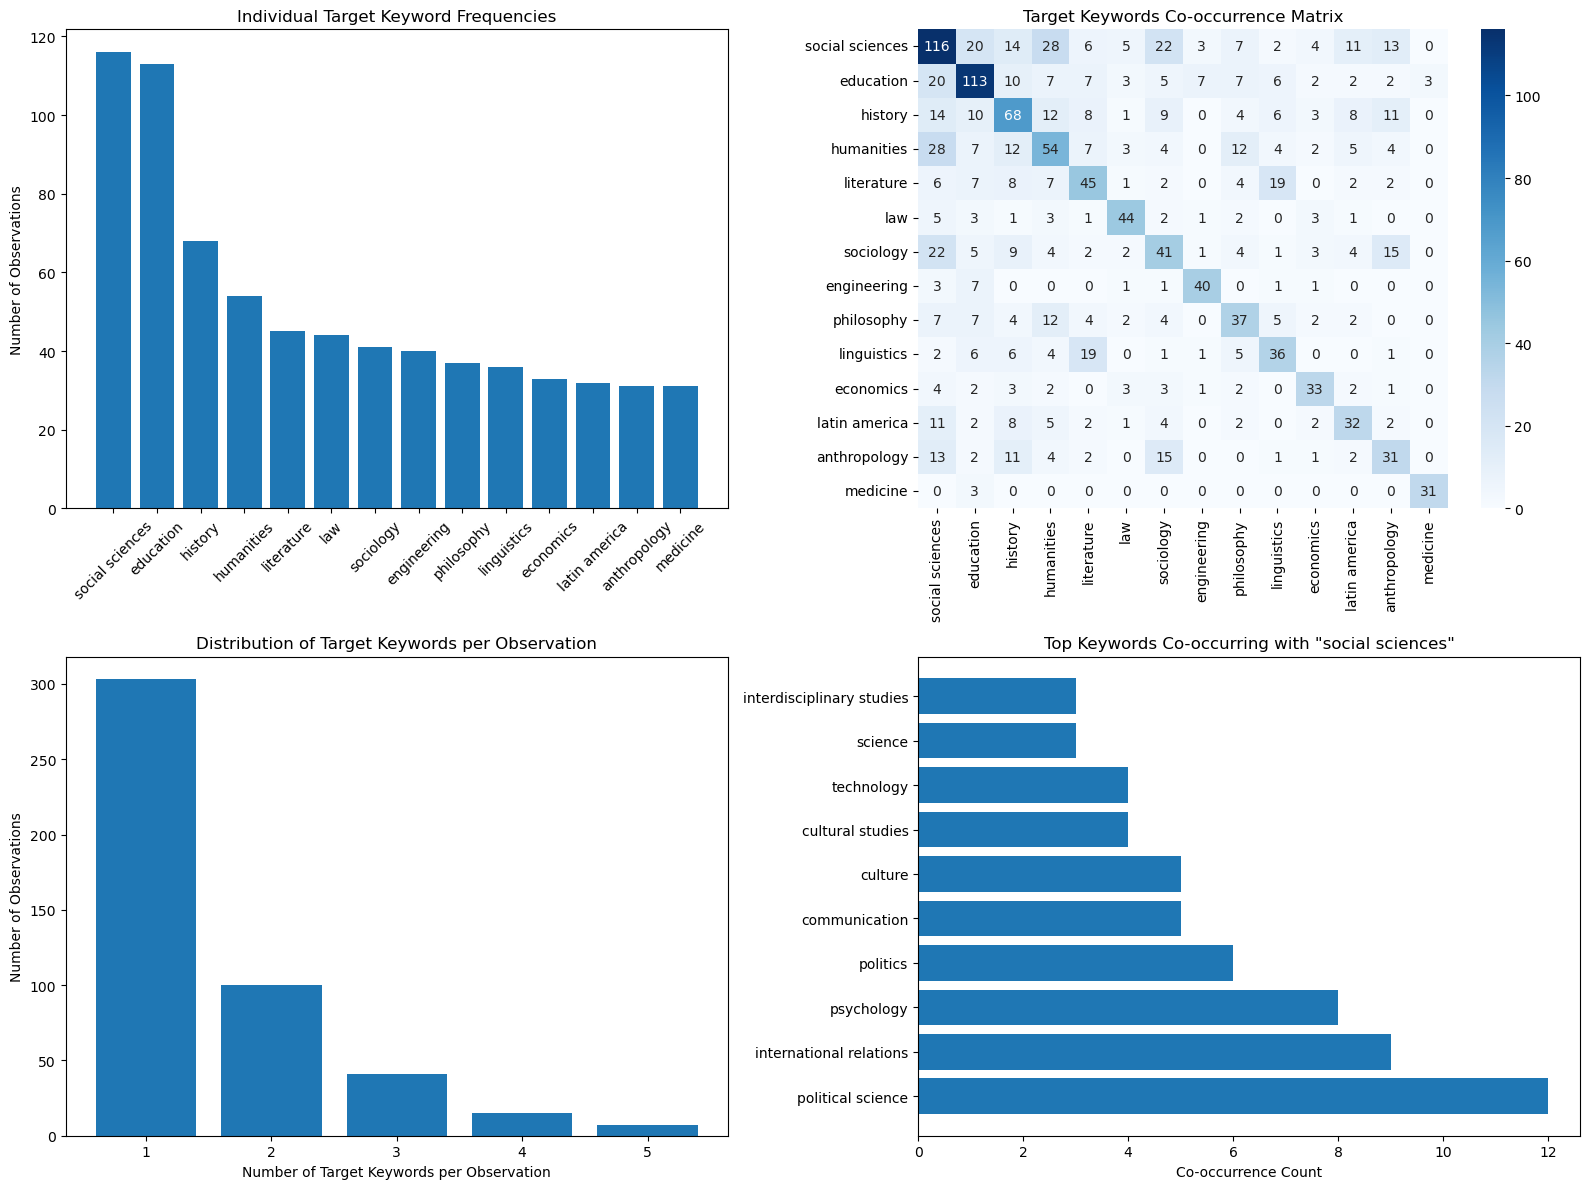


=== SUMMARY STATISTICS ===
Total observations analyzed: 966
Observations with target keywords: 466
Percentage with target keywords: 48.2%
Observations with multiple target keywords: 163
Examples of observations with multiple target keywords:
  Observation 0: ['history', 'humanities']
  Observation 6: ['social sciences', 'humanities']
  Observation 8: ['history', 'sociology', 'anthropology']
  Observation 13: ['education', 'economics']
  Observation 15: ['history', 'latin america']

Detailed results saved to 'target_keywords_analysis.csv'


In [45]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Read the TSV file
df = pd.read_csv('OJS-LatAm-Installations-OJSinDOAJ.tsv', sep='\t')

# Adjust this to match your actual Keywords column name
keywords_column = 'Keywords'

# Target keywords to analyze
target_keywords = ["social sciences", "education", "history", "humanities", "literature", "law", "sociology", "engineering", "philosophy", "linguistics", "economics", "latin america", "anthropology", "medicine"]

print(f"Dataset shape: {df.shape}")
print(f"Analyzing co-occurrence for: {target_keywords}")

# Process keywords for each observation
observations_with_targets = []
all_keywords_per_observation = []

for idx, keywords_cell in enumerate(df[keywords_column].dropna()):
    if pd.notna(keywords_cell) and keywords_cell.strip():
        # Split by comma-space and clean
        keywords = [kw.strip().lower() for kw in str(keywords_cell).split(',')]
        keywords = [kw for kw in keywords if kw]  # Remove empty strings
        
        # Check which target keywords are present in this observation
        present_targets = [kw for kw in target_keywords if kw in keywords]
        
        if present_targets:  # Only keep observations that contain at least one target keyword
            observations_with_targets.append({
                'observation_id': idx,
                'all_keywords': keywords,
                'target_keywords_present': present_targets,
                'num_targets': len(present_targets)
            })

print(f"\nObservations containing at least one target keyword: {len(observations_with_targets)}")

# 1. INDIVIDUAL TARGET KEYWORD FREQUENCIES
print("\n=== INDIVIDUAL TARGET KEYWORD FREQUENCIES ===")
target_counts = {kw: 0 for kw in target_keywords}

for obs in observations_with_targets:
    for target in obs['target_keywords_present']:
        target_counts[target] += 1

for keyword, count in sorted(target_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{keyword}: {count} observations")

# 2. CO-OCCURRENCE BETWEEN TARGET KEYWORDS
print("\n=== CO-OCCURRENCE BETWEEN TARGET KEYWORDS ===")
target_pairs_counts = Counter()

for obs in observations_with_targets:
    targets_in_obs = obs['target_keywords_present']
    if len(targets_in_obs) > 1:
        # Generate pairs of target keywords in this observation
        pairs = combinations(sorted(targets_in_obs), 2)
        target_pairs_counts.update(pairs)

print("Target keyword pairs co-occurrence:")
for pair, count in target_pairs_counts.most_common():
    print(f"  {pair[0]} & {pair[1]}: {count} times")

if not target_pairs_counts:
    print("  No observations contain multiple target keywords together")

# 3. WHAT OTHER KEYWORDS CO-OCCUR WITH EACH TARGET
print("\n=== KEYWORDS THAT CO-OCCUR WITH EACH TARGET ===")

def analyze_cooccurrence_with_target(target_keyword, top_n=10):
    cooccurring_keywords = []
    observations_count = 0
    
    for obs in observations_with_targets:
        if target_keyword in obs['target_keywords_present']:
            observations_count += 1
            # Add all other keywords (excluding our target keywords to focus on new insights)
            other_keywords = [kw for kw in obs['all_keywords'] 
                            if kw != target_keyword and kw not in target_keywords]
            cooccurring_keywords.extend(other_keywords)
    
    cooccur_counts = Counter(cooccurring_keywords)
    
    print(f"\n'{target_keyword}' appears in {observations_count} observations")
    print(f"Top {top_n} keywords that co-occur with '{target_keyword}':")
    
    for keyword, count in cooccur_counts.most_common(top_n):
        percentage = (count / observations_count) * 100
        print(f"  {keyword}: {count} times ({percentage:.1f}% of {target_keyword} observations)")
    
    return cooccur_counts, observations_count

# Analyze each target keyword
cooccurrence_data = {}
for target in target_keywords:
    if target_counts[target] > 0:
        cooccur_counts, obs_count = analyze_cooccurrence_with_target(target)
        cooccurrence_data[target] = {'counts': cooccur_counts, 'total_obs': obs_count}

# 4. CREATE CO-OCCURRENCE MATRIX FOR TARGET KEYWORDS
print("\n=== TARGET KEYWORDS CO-OCCURRENCE MATRIX ===")

# Create a matrix showing co-occurrence between target keywords
target_matrix = np.zeros((len(target_keywords), len(target_keywords)))

for i, kw1 in enumerate(target_keywords):
    for j, kw2 in enumerate(target_keywords):
        if i != j:
            # Count observations containing both keywords
            count = sum(1 for obs in observations_with_targets 
                       if kw1 in obs['target_keywords_present'] and kw2 in obs['target_keywords_present'])
            target_matrix[i, j] = count
        else:
            # Diagonal: individual keyword frequency
            target_matrix[i, j] = target_counts[kw1]

target_matrix_df = pd.DataFrame(target_matrix, 
                               index=target_keywords, 
                               columns=target_keywords)

print(target_matrix_df)

# 5. VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Individual frequencies
axes[0,0].bar(target_keywords, [target_counts[kw] for kw in target_keywords])
axes[0,0].set_title('Individual Target Keyword Frequencies')
axes[0,0].set_ylabel('Number of Observations')
axes[0,0].tick_params(axis='x', rotation=45)

# Co-occurrence heatmap
sns.heatmap(target_matrix_df, annot=True, fmt='g', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Target Keywords Co-occurrence Matrix')

# Distribution of number of target keywords per observation
target_counts_per_obs = [obs['num_targets'] for obs in observations_with_targets]
axes[1,0].hist(target_counts_per_obs, bins=range(1, max(target_counts_per_obs)+2), 
               align='left', rwidth=0.8)
axes[1,0].set_xlabel('Number of Target Keywords per Observation')
axes[1,0].set_ylabel('Number of Observations')
axes[1,0].set_title('Distribution of Target Keywords per Observation')
axes[1,0].set_xticks(range(1, max(target_counts_per_obs)+1))

# Top co-occurring non-target keywords for each target
if cooccurrence_data:
    # Select the most frequent target keyword for detailed analysis
    most_frequent_target = max(target_counts.items(), key=lambda x: x[1])[0]
    top_cooccur = cooccurrence_data[most_frequent_target]['counts'].most_common(10)
    
    if top_cooccur:
        keywords, counts = zip(*top_cooccur)
        axes[1,1].barh(range(len(keywords)), counts)
        axes[1,1].set_yticks(range(len(keywords)))
        axes[1,1].set_yticklabels(keywords)
        axes[1,1].set_xlabel('Co-occurrence Count')
        axes[1,1].set_title(f'Top Keywords Co-occurring with "{most_frequent_target}"')

plt.tight_layout()
plt.show()

# 6. SUMMARY STATISTICS
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total observations analyzed: {len(df)}")
print(f"Observations with target keywords: {len(observations_with_targets)}")
print(f"Percentage with target keywords: {len(observations_with_targets)/len(df)*100:.1f}%")

# Observations with multiple targets
multi_target_obs = [obs for obs in observations_with_targets if obs['num_targets'] > 1]
print(f"Observations with multiple target keywords: {len(multi_target_obs)}")

if multi_target_obs:
    print("Examples of observations with multiple target keywords:")
    for i, obs in enumerate(multi_target_obs[:5]):  # Show first 5 examples
        print(f"  Observation {obs['observation_id']}: {obs['target_keywords_present']}")

# Save detailed results
results_df = pd.DataFrame([
    {'Observation_ID': obs['observation_id'],
     'Target_Keywords': ', '.join(obs['target_keywords_present']),
     'Num_Target_Keywords': obs['num_targets'],
     'All_Keywords': ', '.join(obs['all_keywords'])}
    for obs in observations_with_targets
])

results_df.to_csv('target_keywords_analysis.csv', index=False)
print(f"\nDetailed results saved to 'target_keywords_analysis.csv'")

## Building a Criteria for our corpus

Before moving forward, I would like to test for keyword overlap. 

Selecting:
- sociology (41/68; **<span style="color:lime;background-color:black">postponed</span>**),
- **<span style="color:cyan;background-color:black">engeneering</span>** (40/69) and  
- **<span style="color:salmon;background-color:black">economics</span>** (33/60); and expand the keyword search to subjects (a DOAJ specific field). 

All have similar sizes, they point to debates that can have practical implications and a particular relation with their (social) context and point to broader communities, both, in an epistemic sense and a practical sense. 

> The reason for this decision is based on two previous work; one  stressing the importance of economic development for Latin American Social Sciences , and the relevance for their understanding of latin american societies in connection to globalization (Milia & Arvanitis, 2025). The other, stressing the national threads in technical research work, even in global research fronts, like renewable energies (Milia 2021). Based on these insight, these two topics strike as relevant areas of analysis. 

> " The bidirectional capillarity of social sciences that connects them with crucial intellectual functions in our current world – from advisory functions to training technical workforces – offers a point of entry to map and understand broader societal changes. From this profoundly relational nature, then, different social science disciplines offer a peek into the kind of imagination that the idea of the BRICS has set in motion among different experts and research communities. " (Milia, 2022)


Dataset shape: (966, 57)
Columns: ['ID', 'Journal ISSN (print version)', 'Journal EISSN (online version)', 'Journal title', 'Journal URL', 'URL in DOAJ', 'When did the journal start to publish all content using an open license?', 'Alternative title', 'Journal ISSN (print version).1', 'Journal EISSN (online version).1', 'Keywords', 'Languages in which the journal accepts manuscripts', 'Publisher', 'Country of publisher', 'Other organisation', 'Country of other organisation', 'Journal license', 'License attributes', 'URL for license terms', 'Machine-readable CC licensing information embedded or displayed in articles', 'URL to an example page with embedded licensing information', 'Author holds copyright without restrictions', 'Copyright information URL', 'Review process', 'Review process information URL', 'Journal plagiarism screening policy', 'Plagiarism information URL', "URL for journal's aims & scope", 'URL for the Editorial Board page', "URL for journal's instructions for authors", '

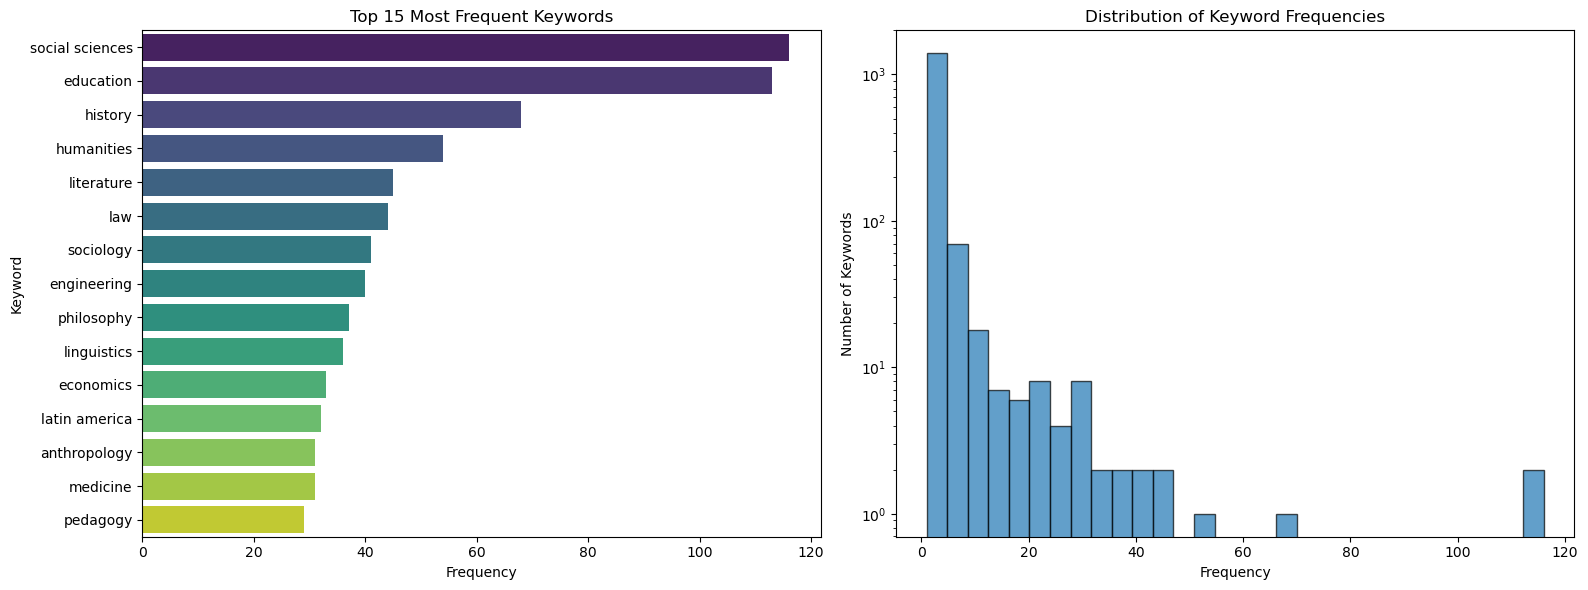


Results saved to 'keyword_counts.csv'

Keyword Statistics:
Keywords appearing only once: 1090
Keywords appearing 5+ times: 133
Keywords appearing 10+ times: 57
Mean frequency: 2.54
Median frequency: 1.00


In [39]:
# import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Read the TSV file
df = pd.read_csv('OJS-LatAm-Installations-OJSinDOAJ.tsv', sep='\t')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Find the Keywords column (case-insensitive search)
keyword_columns = [col for col in df.columns if 'keyword' in col.lower()]
print(f"Potential keyword columns: {keyword_columns}")

# Assuming the column is named 'Keywords' or similar
# Adjust this if your column has a different name
keywords_column = 'Keywords'  # Change this to match your actual column name

# Check if the column exists
if keywords_column not in df.columns:
    print(f"Column '{keywords_column}' not found. Available columns:")
    for col in df.columns:
        print(f"  - {col}")
else:
    # Extract and count keywords
    all_keywords = []
    
    # Process each row's keywords
    for keywords_cell in df[keywords_column].dropna():
        if pd.notna(keywords_cell) and keywords_cell.strip():
            # Split by comma and clean each keyword
            keywords = [kw.strip().lower() for kw in str(keywords_cell).split(',')]
            all_keywords.extend([kw for kw in keywords if kw])  # Filter out empty strings
    
    # Count keyword frequencies
    keyword_counts = Counter(all_keywords)
    
    # Convert to DataFrame for easier analysis
    keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
    keyword_df = keyword_df.sort_values('Count', ascending=False).reset_index(drop=True)
    
    # Display results
    print(f"\nTotal unique keywords: {len(keyword_df)}")
    print(f"Total keyword occurrences: {keyword_df['Count'].sum()}")
    print(f"Most frequent keyword: '{keyword_df.iloc[0]['Keyword']}' ({keyword_df.iloc[0]['Count']} times)")
    
    # Show top 20 keywords
    print("\nTop 20 most frequent keywords:")
    print(keyword_df.head(20))
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 keywords bar plot
    top_15 = keyword_df.head(15)
    sns.barplot(data=top_15, x='Count', y='Keyword', ax=ax1, palette='viridis')
    ax1.set_title('Top 15 Most Frequent Keywords')
    ax1.set_xlabel('Frequency')
    
    # Frequency distribution histogram
    ax2.hist(keyword_df['Count'], bins=30, edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Keyword Frequencies')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Number of Keywords')
    ax2.set_yscale('log')  # Log scale due to likely skewed distribution
    
    plt.tight_layout()
    plt.show()
    
    # Save results to CSV
    keyword_df.to_csv('keyword_counts.csv', index=False)
    print(f"\nResults saved to 'keyword_counts.csv'")
    
    # Additional statistics
    print(f"\nKeyword Statistics:")
    print(f"Keywords appearing only once: {(keyword_df['Count'] == 1).sum()}")
    print(f"Keywords appearing 5+ times: {(keyword_df['Count'] >= 5).sum()}")
    print(f"Keywords appearing 10+ times: {(keyword_df['Count'] >= 10).sum()}")
    print(f"Mean frequency: {keyword_df['Count'].mean():.2f}")
    print(f"Median frequency: {keyword_df['Count'].median():.2f}")

In [40]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("=== SUBJECT FIELD FREQUENCY ANALYSIS ===")

# Read the TSV file
df = pd.read_csv('OJS-LatAm-Installations-OJSinDOAJ.tsv', sep='\t')

# Subject column analysis
subject_column = 'Subject'

print(f"Dataset shape: {df.shape}")
print(f"Analyzing column: '{subject_column}'")
print(f"Looking for pipe separator: '|'")

# Check if the Subject column exists
if subject_column not in df.columns:
    print(f"\nERROR: Column '{subject_column}' not found!")
    print("Available columns in the dataset:")
    for i, col in enumerate(df.columns):
        print(f"  {i+1}. {col}")
    
    # Let user know they might need to adjust the column name
    print("\nIf your subject column has a different name, change the 'subject_column' variable.")
    
else:
    # Show some raw data first to verify we're analyzing the right thing
    print(f"\nSample entries from '{subject_column}' column:")
    sample_data = df[subject_column].dropna().head(3)
    for i, entry in enumerate(sample_data):
        print(f"  Row {i+1}: {str(entry)}")
    
    # Process subjects for each observation
    all_subjects = []
    observations_with_subjects = 0
    empty_entries = 0
    
    for idx, subject_cell in enumerate(df[subject_column]):
        if pd.notna(subject_cell) and str(subject_cell).strip() and str(subject_cell) != 'nan':
            observations_with_subjects += 1
            # Split by pipe separator and clean
            subjects = [subj.strip() for subj in str(subject_cell).split('|')]
            subjects = [subj for subj in subjects if subj and subj != 'nan']  # Remove empty strings
            all_subjects.extend(subjects)
        else:
            empty_entries += 1
    
    print(f"\nProcessing Results:")
    print(f"Total rows in dataset: {len(df)}")
    print(f"Rows with subject data: {observations_with_subjects}")
    print(f"Empty/null subject entries: {empty_entries}")
    print(f"Total subject entries found: {len(all_subjects)}")
    
    if len(all_subjects) > 0:
        # Count subject frequencies
        subject_counts = Counter(all_subjects)
        
        # Convert to DataFrame for easier analysis
        subject_df = pd.DataFrame(subject_counts.items(), columns=['Subject', 'Count'])
        subject_df = subject_df.sort_values('Count', ascending=False).reset_index(drop=True)
        
        # Display results
        print(f"\nSUBJECT FREQUENCY RESULTS:")
        print(f"Unique subjects found: {len(subject_df)}")
        print(f"Total subject occurrences: {subject_df['Count'].sum()}")
        print(f"Average subjects per observation: {len(all_subjects)/observations_with_subjects:.2f}")
        print(f"Most frequent subject: '{subject_df.iloc[0]['Subject']}' ({subject_df.iloc[0]['Count']} times)")
        
        # Show top 15 subjects
        print(f"\nTOP 15 MOST FREQUENT SUBJECTS:")
        print("-" * 50)
        for i, row in subject_df.head(15).iterrows():
            print(f"{i+1:2d}. {row['Subject']}: {row['Count']} times")
        
        # Create visualizations
        print(f"\nCreating visualizations...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Top 15 subjects bar plot
        top_15 = subject_df.head(15)
        bars = ax1.barh(range(len(top_15)), top_15['Count'], color='steelblue', alpha=0.8)
        ax1.set_yticks(range(len(top_15)))
        ax1.set_yticklabels(top_15['Subject'])
        ax1.set_xlabel('Frequency')
        ax1.set_title('Top 15 Most Frequent Subjects')
        ax1.grid(axis='x', alpha=0.3)
        ax1.invert_yaxis()  # Most frequent at top
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width + max(top_15['Count']) * 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=9, weight='bold')
        
        # Frequency distribution histogram
        ax2.hist(subject_df['Count'], bins=min(50, len(subject_df)//2), 
                edgecolor='black', alpha=0.7, color='lightcoral')
        ax2.set_title('Distribution of Subject Frequencies')
        ax2.set_xlabel('Frequency (times subject appears)')
        ax2.set_ylabel('Number of Different Subjects')
        ax2.set_yscale('log')  # Log scale for better visualization
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        # Save visualizations
        plt.savefig('subject_frequency_analysis.png', dpi=300, bbox_inches='tight')
        plt.savefig('subject_frequency_analysis.pdf', bbox_inches='tight')
        plt.show()
        
        # Save results to CSV
        subject_df.to_csv('subject_frequencies.csv', index=False)
        
        # Additional statistics
        print(f"\nSTATISTICS:")
        print(f"Subjects appearing only once: {(subject_df['Count'] == 1).sum()}")
        print(f"Subjects appearing 2-5 times: {((subject_df['Count'] >= 2) & (subject_df['Count'] <= 5)).sum()}")
        print(f"Subjects appearing 5+ times: {(subject_df['Count'] >= 5).sum()}")
        print(f"Subjects appearing 10+ times: {(subject_df['Count'] >= 10).sum()}")
        print(f"Mean frequency: {subject_df['Count'].mean():.2f}")
        print(f"Median frequency: {subject_df['Count'].median():.2f}")
        
        # Create the subject frequency dictionary
        subject_frequency = dict(subject_counts)
        
        print(f"\nOUTPUTS CREATED:")
        print(f"✓ subject_frequency dictionary: {len(subject_frequency)} entries")
        print(f"✓ subject_frequencies.csv: detailed frequency table")
        print(f"✓ subject_frequency_analysis.png/pdf: visualizations")
        
        print(f"\nSample entries from subject_frequency dictionary:")
        for subject, count in list(subject_frequency.items())[:5]:
            print(f"  subject_frequency['{subject}'] = {count}")
            
    else:
        print(f"\nNo subjects found in the '{subject_column}' column.")
        print("This could mean:")
        print("- The column is empty")
        print("- The separator is not '|'") 
        print("- The column name is different")

=== SUBJECT FIELD FREQUENCY ANALYSIS ===
Dataset shape: (966, 57)
Analyzing column: 'Subject'
Looking for pipe separator: '|'

ERROR: Column 'Subject' not found!
Available columns in the dataset:
  1. ID
  2. Journal ISSN (print version)
  3. Journal EISSN (online version)
  4. Journal title
  5. Journal URL
  6. URL in DOAJ
  7. When did the journal start to publish all content using an open license?
  8. Alternative title
  9. Journal ISSN (print version).1
  10. Journal EISSN (online version).1
  11. Keywords
  12. Languages in which the journal accepts manuscripts
  13. Publisher
  14. Country of publisher
  15. Other organisation
  16. Country of other organisation
  17. Journal license
  18. License attributes
  19. URL for license terms
  20. Machine-readable CC licensing information embedded or displayed in articles
  21. URL to an example page with embedded licensing information
  22. Author holds copyright without restrictions
  23. Copyright information URL
  24. Review proc


=== TARGET KEYWORDS CO-OCCURRENCE MATRIX ===
Diagonal: total observations for each keyword
Off-diagonal: how many times keywords co-occur
                 social sciences  education  history  humanities  literature  \
social sciences            116.0       20.0     14.0        28.0         6.0   
education                   20.0      113.0     10.0         7.0         7.0   
history                     14.0       10.0     68.0        12.0         8.0   
humanities                  28.0        7.0     12.0        54.0         7.0   
literature                   6.0        7.0      8.0         7.0        45.0   
law                          5.0        3.0      1.0         3.0         1.0   
sociology                   22.0        5.0      9.0         4.0         2.0   
engineering                  3.0        7.0      0.0         0.0         0.0   
philosophy                   7.0        7.0      4.0        12.0         4.0   
linguistics                  2.0        6.0      6.0         

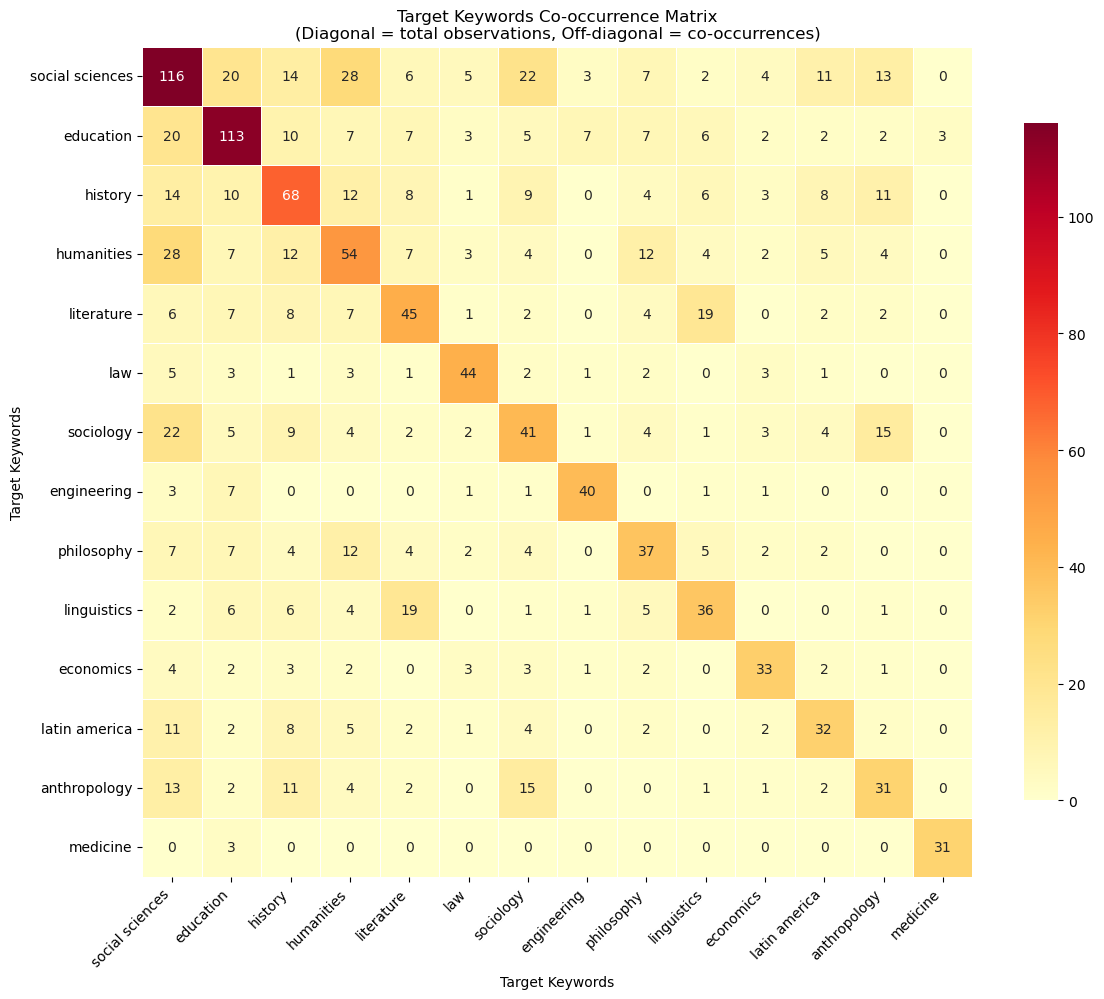


Matrix exported as:
- target_keywords_cooccurrence_matrix.png
- target_keywords_cooccurrence_matrix.pdf
- target_keywords_cooccurrence_matrix.csv


In [27]:
# Add this to the end of your existing analysis script
# This works with the target_matrix_df you already created

import matplotlib.pyplot as plt
import seaborn as sns

# Your script already created target_matrix_df, so we can use it directly
print("\n=== TARGET KEYWORDS CO-OCCURRENCE MATRIX ===")
print("Diagonal: total observations for each keyword")
print("Off-diagonal: how many times keywords co-occur")
print(target_matrix_df)

# Export the matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(target_matrix_df.astype(int), annot=True, fmt='d', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Target Keywords Co-occurrence Matrix\n(Diagonal = total observations, Off-diagonal = co-occurrences)')
plt.xlabel('Target Keywords')
plt.ylabel('Target Keywords')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the matrix plot
plt.savefig('target_keywords_cooccurrence_matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('target_keywords_cooccurrence_matrix.pdf', bbox_inches='tight')
plt.show()

# Save the matrix data to CSV
target_matrix_df.to_csv('target_keywords_cooccurrence_matrix.csv')

print(f"\nMatrix exported as:")
print(f"- target_keywords_cooccurrence_matrix.png")
print(f"- target_keywords_cooccurrence_matrix.pdf") 
print(f"- target_keywords_cooccurrence_matrix.csv")

## Result [decision]
I choose: sociology (41), engeneering (40) and economics (33). 
All of the three have practical implications and have a relation with their context and can point to broader communities, both, in an epistemic sense and a practical sense. 

> " The bidirectional capillarity of social sciences that connects them with crucial intellectual functions in our current world – from advisory functions to training technical workforces – offers a point of entry to map and understand broader societal changes. From this profoundly relational nature, then, different social science disciplines offer a peek into the kind of imagination that the idea of the BRICS has set in motion among different experts and research communities. " (From BRICS chapter)


# **Building two databases**

**Building ~three~ two database** including detailed and text-rich article metadata, one for each discipline. 
Note: originally three, but narrowing down to two, to make it lighter and focus on the "prooof of concept". 



##  Extract the ISSN / EISSN from the list of Latin American Journals (DOAJ-OJS). [3.1]

Script steps: 
1. Read the TSV file
2. Filter journals by keywords
3. Create two types of output files for each keyword
4. Handle the specific variables required

In [46]:
import pandas as pd
import os
from pathlib import Path

def extract_journals_by_keywords(input_file, keywords, output_dir="output"):
    """
    Extract journals from TSV file based on keywords and create two types of output files.
    
    Parameters:
    input_file (str): Path to the input TSV file
    keywords (list): List of keywords to search for
    output_dir (str): Directory to save output files
    """
    
    # Create output directory if it doesn't exist
    print(f"Creating output directory: {output_dir}")
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    try:
        # Check if file exists first
        if not os.path.exists(input_file):
            print(f"ERROR: File '{input_file}' not found in current directory.")
            print(f"Current working directory: {os.getcwd()}")
            print("Files in current directory:")
            for file in os.listdir('.'):
                if file.endswith(('.tsv', '.csv', '.txt')):
                    print(f"  - {file}")
            return False
        
        # Read the TSV file with different encodings if needed
        print(f"Reading file: {input_file}")
        encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        df = None
        
        for encoding in encodings_to_try:
            try:
                df = pd.read_csv(input_file, sep='\t', encoding=encoding)
                print(f"Successfully read file with {encoding} encoding")
                break
            except UnicodeDecodeError:
                print(f"Failed to read with {encoding} encoding, trying next...")
                continue
        
        if df is None:
            print("ERROR: Could not read file with any encoding")
            return False
        
        print(f"Total journals in database: {len(df)}")
        print(f"Total columns: {len(df.columns)}")
        
        # Print all column names for debugging
        print("\nAll available columns:")
        for i, col in enumerate(df.columns, 1):
            print(f"  {i:2d}. '{col}'")
        
        # Look for columns that might contain our target information
        potential_title_cols = [col for col in df.columns if 'title' in col.lower() or 'journal' in col.lower()]
        potential_issn_cols = [col for col in df.columns if 'issn' in col.lower()]
        potential_keyword_cols = [col for col in df.columns if 'keyword' in col.lower() or 'subject' in col.lower()]
        
        print(f"\nPotential title columns: {potential_title_cols}")
        print(f"Potential ISSN columns: {potential_issn_cols}")
        print(f"Potential keyword/subject columns: {potential_keyword_cols}")
        
        # Check if we have the expected columns or similar ones
        required_columns = [
            "Journal title", 
            "Journal ISSN (print version)", 
            "Journal EISSN (online version)",
            "Keywords",
            "Subjects"  # Changed from "﻿﻿Subjects" to "Subjects"
        ]
        
        # Find the best matching columns - simplified since we now know exact names
        column_mapping = {}
        
        for req_col in required_columns:
            if req_col in df.columns:
                column_mapping[req_col] = req_col
                print(f"✓ Found exact match for '{req_col}'")
            else:
                print(f"✗ Column '{req_col}' not found in data")
        
        print(f"\nColumn mapping: {column_mapping}")
        
        if len(column_mapping) < 2:
            print("ERROR: Not enough matching columns found to proceed")
            return False
        
        # Process each keyword
        for keyword in keywords:
            print(f"\n--- Processing keyword: '{keyword}' ---")
            
            # Find columns to search in
            search_columns = []
            for search_col in ["Keywords", "Subjects"]:
                if search_col in column_mapping:
                    search_columns.append(column_mapping[search_col])
            
            if not search_columns:
                print(f"No keyword/subject columns found for searching. Checking all text columns...")
                # Search in all text columns as fallback
                search_columns = [col for col in df.columns if df[col].dtype == 'object']
            
            print(f"Searching in columns: {search_columns}")
            
            # Create search mask
            keyword_mask = pd.Series([False] * len(df))
            for col in search_columns:
                try:
                    mask = df[col].fillna('').str.contains(keyword, case=False, na=False)
                    keyword_mask = keyword_mask | mask
                    matches_in_col = mask.sum()
                    print(f"  Found {matches_in_col} matches in column '{col}'")
                except Exception as e:
                    print(f"  Error searching in column '{col}': {e}")
            
            # Filter journals that match the keyword
            matching_journals = df[keyword_mask].copy()
            
            print(f"Total journals matching '{keyword}': {len(matching_journals)}")
            
            if len(matching_journals) == 0:
                print(f"No journals found for keyword '{keyword}'. Skipping...")
                continue
            
            # File 1: Essential information only - include all 5 required columns
            essential_columns = []
            for req_col in required_columns:
                if req_col in column_mapping:
                    essential_columns.append(column_mapping[req_col])
            
            print(f"  Essential columns to include: {essential_columns}")
            
            if essential_columns:
                essential_data = matching_journals[essential_columns].copy()
                
                # Save essential data
                essential_filename = f"{keyword}_essential.tsv"
                essential_path = os.path.join(output_dir, essential_filename)
                essential_data.to_csv(essential_path, sep='\t', index=False, encoding='utf-8')
                print(f"  ✓ Saved essential data: {essential_filename} ({len(essential_data)} rows, {len(essential_data.columns)} columns)")
                print(f"    Columns: {list(essential_data.columns)}")
            else:
                print(f"  ⚠ No essential columns found - skipping essential file for {keyword}")
            
            # File 2: All variables for matching journals
            complete_filename = f"{keyword}_complete.tsv"
            complete_path = os.path.join(output_dir, complete_filename)
            matching_journals.to_csv(complete_path, sep='\t', index=False, encoding='utf-8')
            print(f"  ✓ Saved complete data: {complete_filename} ({len(matching_journals)} rows, {len(matching_journals.columns)} columns)")
            
            # Print sample of results for verification
            title_col = column_mapping.get("Journal title", df.columns[0])
            print(f"  Sample journals for '{keyword}' (showing {title_col}):")
            for idx, row in matching_journals.head(3).iterrows():
                title = row[title_col] if title_col in row else 'N/A'
                print(f"    - {title}")
        
        return True
    
    except FileNotFoundError:
        print(f"ERROR: File '{input_file}' not found.")
        return False
    except Exception as e:
        print(f"ERROR processing file: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

def main():
    """
    Main function to execute the journal extraction process.
    """
    # Configuration
    input_file = "OJS-LatAm-Installations-OJSinDOAJ.tsv"
    keywords = ["sociology", "engineering", "economics"]
    output_dir = "journal_extracts"
    
    print("=== Journal Keyword Extraction Script ===")
    print(f"Input file: {input_file}")
    print(f"Keywords: {', '.join(keywords)}")
    print(f"Output directory: {output_dir}")
    print()
    
    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"Error: Input file '{input_file}' not found in current directory.")
        print("Please ensure the file is in the same directory as this script.")
        return
    
    # Extract journals by keywords
    success = extract_journals_by_keywords(input_file, keywords, output_dir)
    
    if success:
        print(f"\n=== Process Complete ===")
        print(f"Output files saved in '{output_dir}' directory:")
        print("For each keyword, you'll find:")
        print("  - [keyword]_essential.tsv: Contains only title, ISSN, EISSN, keywords, and subjects")
        print("  - [keyword]_complete.tsv: Contains all variables for matching journals")
        
        # List the actual files created
        if os.path.exists(output_dir):
            files_created = [f for f in os.listdir(output_dir) if f.endswith('.tsv')]
            if files_created:
                print(f"\nFiles created ({len(files_created)}):")
                for file in sorted(files_created):
                    file_path = os.path.join(output_dir, file)
                    file_size = os.path.getsize(file_path)
                    print(f"  - {file} ({file_size} bytes)")
            else:
                print("\nWARNING: No TSV files were created in the output directory")
    else:
        print(f"\n=== Process Failed ===")
        print("Please check the error messages above and ensure:")
        print("1. The TSV file exists in the current directory")
        print("2. The file has the expected column structure")
        print("3. The file is not corrupted or locked by another program")

if __name__ == "__main__":
    main()

=== Journal Keyword Extraction Script ===
Input file: OJS-LatAm-Installations-OJSinDOAJ.tsv
Keywords: sociology, engineering, economics
Output directory: journal_extracts

Creating output directory: journal_extracts
Reading file: OJS-LatAm-Installations-OJSinDOAJ.tsv
Successfully read file with utf-8 encoding
Total journals in database: 966
Total columns: 57

All available columns:
   1. 'ID'
   2. 'Journal ISSN (print version)'
   3. 'Journal EISSN (online version)'
   4. 'Journal title'
   5. 'Journal URL'
   6. 'URL in DOAJ'
   7. 'When did the journal start to publish all content using an open license?'
   8. 'Alternative title'
   9. 'Journal ISSN (print version).1'
  10. 'Journal EISSN (online version).1'
  11. 'Keywords'
  12. 'Languages in which the journal accepts manuscripts'
  13. 'Publisher'
  14. 'Country of publisher'
  15. 'Other organisation'
  16. 'Country of other organisation'
  17. 'Journal license'
  18. 'License attributes'
  19. 'URL for license terms'
  20. 'Mac

## Analize the structure of the database across the different JSON batches. [3.2.]

In [55]:
#!/usr/bin/env python3
"""
JSON Format Detective: Determine the actual structure of your batch files
"""

import json
import os

def detect_json_format(filename, max_chars=5000):
    """Detect the JSON format of a batch file."""
    
    if not os.path.exists(filename):
        print(f"❌ File not found: {filename}")
        return None
    
    print(f"\n🔍 Analyzing: {filename}")
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            # Read first chunk to analyze
            content = f.read(max_chars)
            print(f"📄 First {len(content)} characters:")
            print("-" * 50)
            print(content[:500] + "..." if len(content) > 500 else content)
            print("-" * 50)
            
            # Reset file pointer
            f.seek(0)
            full_content = f.read()
            
            # Test different parsing strategies
            print(f"\n🧪 Testing parsing strategies:")
            
            # Strategy 1: Single JSON array
            try:
                data = json.loads(full_content)
                if isinstance(data, list):
                    print(f"✅ Format: Single JSON array with {len(data)} records")
                    return "json_array", data
                else:
                    print(f"✅ Format: Single JSON object")
                    return "single_json", data
            except json.JSONDecodeError as e:
                print(f"❌ Not a single JSON: {e}")
            
            # Strategy 2: JSONL (one JSON per line)
            try:
                lines = full_content.strip().split('\n')
                records = []
                for i, line in enumerate(lines[:5]):  # Test first 5 lines
                    if line.strip():
                        record = json.loads(line)
                        records.append(record)
                print(f"✅ Format: JSONL (JSON Lines) with {len(lines)} lines")
                return "jsonl", records[:3]  # Return sample
            except json.JSONDecodeError as e:
                print(f"❌ Not JSONL: {e}")
            
            # Strategy 3: Concatenated JSON objects (your likely case)
            try:
                records = []
                decoder = json.JSONDecoder()
                idx = 0
                
                while idx < len(full_content):
                    # Skip whitespace
                    while idx < len(full_content) and full_content[idx].isspace():
                        idx += 1
                    
                    if idx >= len(full_content):
                        break
                    
                    # Try to parse JSON object starting at idx
                    obj, end_idx = decoder.raw_decode(full_content, idx)
                    records.append(obj)
                    idx += end_idx
                    
                    if len(records) >= 5:  # Limit for testing
                        break
                
                print(f"✅ Format: Concatenated JSON objects, found {len(records)} in sample")
                return "concatenated_json", records
                
            except json.JSONDecodeError as e:
                print(f"❌ Not concatenated JSON: {e}")
            
            # Strategy 4: Check for other patterns
            print(f"🔍 Content analysis:")
            print(f"  Total length: {len(full_content)} characters")
            print(f"  Starts with: {repr(full_content[:50])}")
            print(f"  Ends with: {repr(full_content[-50:])}")
            print(f"  Contains newlines: {full_content.count(chr(10))}")
            print(f"  Contains {{ characters: {full_content.count('{')}")
            print(f"  Contains }} characters: {full_content.count('}')}")
            
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None
    
    print(f"❓ Unknown format - manual inspection needed")
    return "unknown", None

def main():
    """Detect format of the first few batch files."""
    
    print("JSON Format Test")
    print("=" * 40)
    
    # Test first 3 batch files
    for batch_num in range(1, 4):
        filename = f"article_batch_{batch_num}.json"
        result = detect_json_format(filename)
        
        if result and result[0] != "unknown":
            format_type, sample_data = result
            print(f"\n📋 Sample record structure:")
            if sample_data:
                if isinstance(sample_data, list) and sample_data:
                    sample_record = sample_data[0]
                else:
                    sample_record = sample_data
                
                # Show the structure of bibjson section
                if isinstance(sample_record, dict):
                    bibjson = sample_record.get('bibjson', {})
                    if bibjson:
                        print("  🔍 bibjson.identifier:")
                        identifiers = bibjson.get('identifier', [])
                        for i, identifier in enumerate(identifiers):
                            print(f"    [{i}]: {identifier}")
                        
                        print("  🔍 bibjson.journal:")
                        journal = bibjson.get('journal', {})
                        print(f"    title: {journal.get('title', 'N/A')}")
                        print(f"    issns: {journal.get('issns', 'N/A')}")
            
            break  # Found the format, no need to test more files

if __name__ == "__main__":
    main()

🕵️ JSON Format Detective

🔍 Analyzing: article_batch_1.json
📄 First 5000 characters:
--------------------------------------------------
[{"last_updated": "2022-12-21T16:50:04Z", "bibjson": {"identifier": [{"id": "10.3390/ijms23031788", "type": "doi"}, {"id": "1422-0067", "type": "eissn"}, {"id": "1661-6596", "type": "pissn"}], "journal": {"volume": "23", "number": "1788", "country": "CH", "issns": ["1422-0067", "1661-6596"], "publisher": "MDPI AG", "language": ["EN"], "title": "International Journal of Molecular Sciences"}, "month": "02", "keywords": ["breast cancer metastasis", "cytoplasmic chromatin fragments", "EZH2", "cGAS",...
--------------------------------------------------

🧪 Testing parsing strategies:
✅ Format: Single JSON array with 100000 records

📋 Sample record structure:
  🔍 bibjson.identifier:
    [0]: {'id': '10.3390/ijms23031788', 'type': 'doi'}
    [1]: {'id': '1422-0067', 'type': 'eissn'}
    [2]: {'id': '1661-6596', 'type': 'pissn'}
  🔍 bibjson.journal:
    title:

### ISSN Finder, what are the good ISSNs?

**Purpose:** Two complementary diagnostic tools to identify which target ISSNs exist in the DOAJ database and analyze coverage gaps for journal identification.

### Simple ISSN Finder
**Methodology:** Fast text-based string search across all 95 DOAJ batch files to determine basic ISSN presence without complex JSON parsing.

**Key Features:**
- Direct string matching in raw file content
- Progress tracking with real-time feedback
- Simple existence verification (binary found/not found)
- File location tracking for each discovered ISSN

### Missing ISSNs Analyzer
**Methodology:** Detailed analysis of ISSNs not found in DOAJ database with comprehensive reporting and pattern identification.

**Analysis Features:**
- Discipline-based categorization (economics vs engineering)
- ISSN type classification (print vs electronic)
- Pattern analysis for potential format issues
- Detailed reporting with journal title context

**Combined Results:**
- **Total target ISSNs:** 230 unique identifiers from both disciplines
- **Success rate:** 87.4% (201 out of 230 ISSNs found in DOAJ)
- **Missing ISSNs:** 29 identifiers not present in database

**Output Reports:**
- Console summary with found/missing statistics
- `missing_issns_report.csv` - Structured data of unfound ISSNs with journal details
- File location mapping for successful matches

**Diagnostic Value:** Essential validation step that confirmed TSV format issues and provided confidence metrics for subsequent record extraction, ensuring data quality before processing millions of records.

**Research Insight:** High success rate (87.4%) validates that target journal collections are well-represented in DOAJ database, with missing ISSNs likely representing journals not indexed in DOAJ or using alternative identification systems.

In [63]:
#!/usr/bin/env python3
"""
Simple ISSN Finder: Check if target ISSNs exist ANYWHERE in the DOAJ batch files
No complex parsing - just search for the string values directly in the JSON text.
"""

import csv
import os
from tqdm import tqdm

def load_target_issns():
    """Load target ISSNs from CSV files."""
    target_issns = set()
    
    for csv_file in ['economics_journal_ids.csv', 'engineering_journal_ids.csv']:
        if not os.path.exists(csv_file):
            continue
            
        print(f"📊 Loading {csv_file}")
        with open(csv_file, 'r', encoding='utf-8') as f:
            # Use tab delimiter since files are TSV format
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                issn_print = row.get('ISSN', '').strip()  # Column name is 'ISSN'
                eissn_online = row.get('EISSN', '').strip()  # Column name is 'EISSN'
                
                if issn_print:
                    target_issns.add(issn_print)
                if eissn_online:
                    target_issns.add(eissn_online)
    
    print(f"🎯 Total target ISSNs: {len(target_issns)}")
    print(f"📋 Sample ISSNs: {sorted(list(target_issns))[:10]}")
    return target_issns

def search_issns_in_files(target_issns, max_files=95):
    """Search for target ISSNs in batch files by simple string matching."""
    
    found_issns = {}  # issn -> list of files where found
    
    print(f"\n🔍 Searching for {len(target_issns)} ISSNs in up to {max_files} batch files...")
    
    for batch_num in tqdm(range(1, max_files + 1), desc="Searching files"):
        filename = f"article_batch_{batch_num}.json"
        
        if not os.path.exists(filename):
            continue
            
        try:
            # Read entire file as text (simple approach)
            with open(filename, 'r', encoding='utf-8') as f:
                file_content = f.read()
            
            # Check each target ISSN
            for issn in target_issns:
                if issn in file_content:
                    if issn not in found_issns:
                        found_issns[issn] = []
                    found_issns[issn].append(filename)
                    
        except Exception as e:
            tqdm.write(f"Error reading {filename}: {e}")
            continue
    
    return found_issns

def main():
    """Simple ISSN existence check."""
    print("🔍 SIMPLE ISSN FINDER")
    print("Just checking if the ISSN strings exist anywhere in the files...")
    print("=" * 50)
    
    # Load target ISSNs
    target_issns = load_target_issns()
    
    if not target_issns:
        print("❌ No target ISSNs found!")
        return
    
    # Search for them
    found_issns = search_issns_in_files(target_issns)
    
    # Report results
    print(f"\n📊 RESULTS:")
    print(f"  Target ISSNs: {len(target_issns)}")
    print(f"  Found ISSNs: {len(found_issns)}")
    
    if found_issns:
        print(f"\n✅ FOUND ISSNs:")
        for issn, files in sorted(found_issns.items()):
            print(f"  {issn}: found in {len(files)} files")
            if len(files) <= 5:
                print(f"    Files: {files}")
            else:
                print(f"    Files: {files[:3]} ... and {len(files)-3} more")
    else:
        print(f"\n❌ NO ISSNs FOUND")
        print(f"This means either:")
        print(f"  1. The ISSNs are not in the DOAJ database")
        print(f"  2. They're formatted differently")
        print(f"  3. There's an encoding or file reading issue")
        
        print(f"\n🔍 Let's check a few things...")
        
        # Show sample of what we're looking for
        sample_issns = sorted(list(target_issns))[:5]
        print(f"  Sample target ISSNs we're searching for:")
        for issn in sample_issns:
            print(f"    '{issn}' (length: {len(issn)})")
        
        # Check first file content
        first_file = "article_batch_1.json"
        if os.path.exists(first_file):
            print(f"\n  Sample content from {first_file}:")
            with open(first_file, 'r', encoding='utf-8') as f:
                content = f.read(1000)  # First 1000 chars
                print(f"    {repr(content)}")
                
                # Check for any ISSN-like patterns
                import re
                issn_patterns = re.findall(r'\d{4}-\d{3}[\dXx]', content)
                if issn_patterns:
                    print(f"  ISSN patterns found in sample: {issn_patterns}")
                else:
                    print(f"  No ISSN patterns found in sample")

if __name__ == "__main__":
    main()

Searching files:   0%|                                   | 0/95 [00:00<?, ?it/s]

🔍 SIMPLE ISSN FINDER
Just checking if the ISSN strings exist anywhere in the files...
📊 Loading economics_journal_ids.csv
📊 Loading engineering_journal_ids.csv
🎯 Total target ISSNs: 230
📋 Sample ISSNs: ['0012-7353', '0034-8066', '0041-3011', '0101-7004', '0101-8191', '0104-0960', '0120-100X', '0120-2596', '0120-3053', '0120-4645']

🔍 Searching for 230 ISSNs in up to 95 batch files...


Searching files: 100%|██████████████████████████| 95/95 [35:24<00:00, 22.36s/it]


📊 RESULTS:
  Target ISSNs: 230
  Found ISSNs: 201

✅ FOUND ISSNs:
  0012-7353: found in 70 files
    Files: ['article_batch_6.json', 'article_batch_7.json', 'article_batch_8.json'] ... and 67 more
  0034-8066: found in 15 files
    Files: ['article_batch_2.json', 'article_batch_7.json', 'article_batch_8.json'] ... and 12 more
  0041-3011: found in 6 files
    Files: ['article_batch_24.json', 'article_batch_40.json', 'article_batch_82.json'] ... and 3 more
  0101-7004: found in 76 files
    Files: ['article_batch_1.json', 'article_batch_2.json', 'article_batch_3.json'] ... and 73 more
  0101-8191: found in 54 files
    Files: ['article_batch_7.json', 'article_batch_8.json', 'article_batch_11.json'] ... and 51 more
  0120-100X: found in 46 files
    Files: ['article_batch_1.json', 'article_batch_2.json', 'article_batch_4.json'] ... and 43 more
  0120-2596: found in 87 files
    Files: ['article_batch_1.json', 'article_batch_2.json', 'article_batch_3.json'] ... and 84 more
  0120-3053: f

In [65]:
## Looking at the ISSNs that **did not** get any matches

#!/usr/bin/env python3
"""
Missing ISSNs Finder: Identify which 29 ISSNs are not found in DOAJ
"""

import csv
import os
from tqdm import tqdm

def load_target_issns_with_details():
    """Load target ISSNs with journal title information."""
    issn_details = {}  # issn -> {title, source_file, issn_type}
    all_issns = set()
    
    for csv_file in ['economics_journal_ids.csv', 'engineering_journal_ids.csv']:
        if not os.path.exists(csv_file):
            continue
            
        discipline = csv_file.replace('_journal_ids.csv', '')
        print(f"📊 Loading {csv_file}")
        
        with open(csv_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                journal_title = row.get('Journal_title', '').strip()
                issn_print = row.get('ISSN', '').strip()
                eissn_online = row.get('EISSN', '').strip()
                
                if issn_print:
                    all_issns.add(issn_print)
                    issn_details[issn_print] = {
                        'title': journal_title,
                        'source': discipline,
                        'type': 'ISSN (print)'
                    }
                
                if eissn_online:
                    all_issns.add(eissn_online)
                    issn_details[eissn_online] = {
                        'title': journal_title,
                        'source': discipline,
                        'type': 'EISSN (electronic)'
                    }
    
    print(f"🎯 Total target ISSNs: {len(all_issns)}")
    return all_issns, issn_details

def find_issns_in_doaj(target_issns, max_files=95):
    """Find which ISSNs exist in DOAJ files."""
    found_issns = set()
    issn_file_locations = {}  # issn -> list of files where found
    
    print(f"\n🔍 Searching for {len(target_issns)} ISSNs in DOAJ files...")
    
    for batch_num in tqdm(range(1, max_files + 1), desc="Searching files"):
        filename = f"article_batch_{batch_num}.json"
        
        if not os.path.exists(filename):
            continue
            
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                file_content = f.read()
            
            # Check each target ISSN
            for issn in target_issns:
                if issn in file_content:
                    found_issns.add(issn)
                    if issn not in issn_file_locations:
                        issn_file_locations[issn] = []
                    issn_file_locations[issn].append(filename)
                    
        except Exception as e:
            tqdm.write(f"Error reading {filename}: {e}")
            continue
    
    return found_issns, issn_file_locations

def analyze_missing_issns(target_issns, found_issns, issn_details):
    """Analyze the ISSNs that were not found."""
    missing_issns = target_issns - found_issns
    
    print(f"\n📊 ANALYSIS RESULTS:")
    print(f"  Target ISSNs: {len(target_issns)}")
    print(f"  Found ISSNs: {len(found_issns)}")
    print(f"  Missing ISSNs: {len(missing_issns)}")
    print(f"  Success rate: {len(found_issns)/len(target_issns)*100:.1f}%")
    
    if missing_issns:
        print(f"\n❌ MISSING ISSNs ({len(missing_issns)} total):")
        print("=" * 60)
        
        # Group by discipline
        economics_missing = []
        engineering_missing = []
        
        for issn in sorted(missing_issns):
            details = issn_details.get(issn, {})
            if details.get('source') == 'economics':
                economics_missing.append((issn, details))
            elif details.get('source') == 'engineering':
                engineering_missing.append((issn, details))
        
        if economics_missing:
            print(f"\n📚 ECONOMICS - Missing ISSNs ({len(economics_missing)}):")
            for issn, details in economics_missing:
                print(f"  {issn} ({details.get('type', 'unknown')}) - {details.get('title', 'No title')}")
        
        if engineering_missing:
            print(f"\n⚙️ ENGINEERING - Missing ISSNs ({len(engineering_missing)}):")
            for issn, details in engineering_missing:
                print(f"  {issn} ({details.get('type', 'unknown')}) - {details.get('title', 'No title')}")
        
        # Pattern analysis
        print(f"\n🔍 PATTERN ANALYSIS OF MISSING ISSNs:")
        print(f"  Missing ISSN (print): {sum(1 for issn in missing_issns if issn_details.get(issn, {}).get('type', '').startswith('ISSN'))}")
        print(f"  Missing EISSN (electronic): {sum(1 for issn in missing_issns if issn_details.get(issn, {}).get('type', '').startswith('EISSN'))}")
        
        # Check for potential format issues
        print(f"\n💡 POTENTIAL REASONS FOR MISSING ISSNs:")
        print(f"  1. Journals not included in DOAJ database")
        print(f"  2. ISSNs changed or discontinued")
        print(f"  3. Slight format differences (spaces, case, etc.)")
        print(f"  4. Data quality issues in source files")
    
    return missing_issns

def save_missing_issns_report(missing_issns, issn_details):
    """Save missing ISSNs to a file for reference."""
    if not missing_issns:
        return
    
    filename = "missing_issns_report.csv"
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['ISSN', 'Type', 'Journal_Title', 'Discipline'])
        
        for issn in sorted(missing_issns):
            details = issn_details.get(issn, {})
            writer.writerow([
                issn,
                details.get('type', 'unknown'),
                details.get('title', 'No title'),
                details.get('source', 'unknown')
            ])
    
    print(f"\n💾 Missing ISSNs report saved to: {filename}")

def main():
    """Identify missing ISSNs."""
    print("🔍 MISSING ISSNs IDENTIFIER")
    print("Finding which 29 ISSNs are not in DOAJ...")
    print("=" * 50)
    
    # Load target ISSNs with details
    target_issns, issn_details = load_target_issns_with_details()
    
    if not target_issns:
        print("❌ No target ISSNs found!")
        return
    
    # Find ISSNs in DOAJ
    found_issns, issn_file_locations = find_issns_in_doaj(target_issns)
    
    # Analyze missing ones
    missing_issns = analyze_missing_issns(target_issns, found_issns, issn_details)
    
    # Save report
    if missing_issns:
        save_missing_issns_report(missing_issns, issn_details)
    
    # Show some found ISSNs for context
    if found_issns:
        print(f"\n✅ SAMPLE FOUND ISSNs (for context):")
        sample_found = sorted(list(found_issns))[:10]
        for issn in sample_found:
            details = issn_details.get(issn, {})
            print(f"  {issn} - {details.get('title', 'No title')}")

if __name__ == "__main__":
    main()

Searching files:   0%|                                   | 0/95 [00:00<?, ?it/s]

🔍 MISSING ISSNs IDENTIFIER
Finding which 29 ISSNs are not in DOAJ...
📊 Loading economics_journal_ids.csv
📊 Loading engineering_journal_ids.csv
🎯 Total target ISSNs: 230

🔍 Searching for 230 ISSNs in DOAJ files...


Searching files: 100%|██████████████████████████| 95/95 [35:37<00:00, 22.50s/it]


📊 ANALYSIS RESULTS:
  Target ISSNs: 230
  Found ISSNs: 201
  Missing ISSNs: 29
  Success rate: 87.4%

❌ MISSING ISSNs (29 total):

📚 ECONOMICS - Missing ISSNs (14):
  0104-0960 (ISSN (print)) - Revista Teoria e Evidencia Economica
  0252-8584 (ISSN (print)) - Economia y Desarrollo
  1390-7921 (ISSN (print)) - Revista Economia y Politica
  1517-6258 (ISSN (print)) - Informe Economico
  2318-8448 (EISSN (electronic)) - Revista Teoria e Evidencia Economica
  2339-3645 (ISSN (print)) - Revista Colombiana de Contabilidad
  2477-9075 (EISSN (electronic)) - Revista Economia y Politica
  2518-0983 (EISSN (electronic)) - Economia y Desarrollo
  2528-7931 (ISSN (print)) - Boletin de Coyuntura
  2539-0678 (ISSN (print)) - Revista Lumen Gentium
  2590-874X (EISSN (electronic)) - Revista Lumen Gentium
  2600-5727 (EISSN (electronic)) - Boletin de Coyuntura
  2764-1392 (EISSN (electronic)) - Informe Economico
  2805-8658 (EISSN (electronic)) - Accounting and Management Research

⚙️ ENGINEERING - Mi

### Detecting entries for ISSN/eISSN with no records [FAILED]

I **Curated results and added DOI prefix/root**. Below, I am trying to detect records that match these prefix hoping to be able to find missing records. The problem is that the prefix can be used by a whole editor (let's say a university) and this can be tricky, since is hard to establish a relation to the specific journal. 

**Purpose:** Search for journal records in DOAJ database using DOI prefixes as an alternative identification method for journals that may not have standardized ISSN indexing.

**Target Journals:**
- Ciencia y Tecnologia de Buques (10.25043/)
- Ingenieria e Innovacion (10.21897/)
- Informe Economico (10.26694/)
- Revista Colombiana de Contabilidad (10.56241/)
- Accounting and Management Research (10.22209/)
- Revista Economia y Politica (10.25097/)

**Search Methodology:**
1. **Text-based search**: Fast string matching across all 95 DOAJ batch files
2. **JSON parsing**: Detailed record extraction when prefix matches are found
3. **DOI validation**: Extract specific DOI identifiers from matched records
4. **Full record extraction**: Complete scan to capture all matching records

**Processing Features:**
- **Dual-stage search**: Combines fast text search with detailed JSON analysis
- **Progress tracking**: Real-time processing feedback with tqdm progress bars
- **Sample collection**: Stores representative records for manual validation
- **Error handling**: Graceful handling of malformed JSON and missing files

**Output Files:**
- `doi_prefix_matched_records.jsonl` - All records matching DOI prefix patterns
- Console summary with match statistics and journal-specific counts

**Limitations:**
- **High false positive potential**: DOI prefixes may capture unrelated publications from same publisher
- **Broad scope**: Publisher-level prefixes rather than journal-specific identifiers
- **Quality concerns**: Requires manual validation to ensure records belong to target journals

**Research Application:** Designed as supplementary method for journals with inconsistent ISSN indexing, though analysis showed prefix matching was too broad for reliable journal identification. Script demonstrates alternative approaches for bibliographic record

In [66]:
#!/usr/bin/env python3
"""
DOI Prefix Detector: Search for journal records using DOI prefixes
For journals that use DOI indexing instead of standardized ISSN
"""

import json
import os
import re
from tqdm import tqdm
from collections import defaultdict

def load_doi_prefixes():
    """Load DOI prefixes and journal names."""
    doi_prefixes = {
        "10.25043/": "Ciencia y Tecnologia de Buques",
        "10.21897/": "Ingenieria e Innovacion", 
        "10.26694/": "Informe Economico",
        "10.56241/": "Revista Colombiana de Contabilidad",
        "10.22209/": "Accounting and Management Research",
        "10.25097/": "Revista Economia y Politica"
    }
    
    print(f"🎯 Target DOI prefixes: {len(doi_prefixes)}")
    for prefix, journal in doi_prefixes.items():
        print(f"  {prefix} - {journal}")
    
    return doi_prefixes

def search_doi_prefixes_in_files(doi_prefixes, max_files=95):
    """Search for DOI prefixes in DOAJ batch files."""
    
    found_prefixes = defaultdict(list)  # prefix -> list of (file, matches_count)
    total_matches = 0
    sample_records = defaultdict(list)  # prefix -> sample records
    
    print(f"\n🔍 Searching for {len(doi_prefixes)} DOI prefixes in up to {max_files} batch files...")
    
    for batch_num in tqdm(range(1, max_files + 1), desc="Searching files"):
        filename = f"article_batch_{batch_num}.json"
        
        if not os.path.exists(filename):
            continue
            
        try:
            # Method 1: Simple text search first (fast)
            with open(filename, 'r', encoding='utf-8') as f:
                file_content = f.read()
            
            file_matches = {}
            for prefix in doi_prefixes:
                # Count how many times this prefix appears in the file
                matches = file_content.count(prefix)
                if matches > 0:
                    file_matches[prefix] = matches
                    found_prefixes[prefix].append((filename, matches))
                    total_matches += matches
            
            # Method 2: If we found matches, parse JSON to get actual records (more detailed)
            if file_matches:
                try:
                    with open(filename, 'r', encoding='utf-8') as f:
                        records_array = json.load(f)
                    
                    for record_idx, record in enumerate(records_array):
                        # Convert record to string to search for DOI patterns
                        record_str = json.dumps(record)
                        
                        for prefix in file_matches:
                            if prefix in record_str:
                                # Store sample record for inspection
                                if len(sample_records[prefix]) < 3:  # Keep max 3 samples per prefix
                                    sample_records[prefix].append({
                                        'file': filename,
                                        'record_idx': record_idx,
                                        'record_id': record.get('id', f'record_{record_idx}'),
                                        'journal_title': record.get('bibjson', {}).get('journal', {}).get('title', 'No title'),
                                        'doi_found': extract_doi_from_record(record, prefix),
                                        'record': record  # Store full record for later use
                                    })
                
                except json.JSONDecodeError:
                    tqdm.write(f"Could not parse JSON in {filename} for detailed analysis")
                    continue
                    
        except Exception as e:
            tqdm.write(f"Error reading {filename}: {e}")
            continue
    
    return found_prefixes, sample_records, total_matches

def extract_doi_from_record(record, prefix):
    """Extract the specific DOI(s) from a record that match the prefix."""
    dois = []
    
    try:
        bibjson = record.get('bibjson', {})
        identifiers = bibjson.get('identifier', [])
        
        for identifier in identifiers:
            if isinstance(identifier, dict):
                id_type = identifier.get('type', '').lower()
                id_value = identifier.get('id', '')
                
                if id_type == 'doi' and prefix in id_value:
                    dois.append(id_value)
    
    except Exception:
        pass
    
    return dois

def analyze_results(found_prefixes, sample_records, doi_prefixes, total_matches):
    """Analyze and display the results."""
    
    print(f"\n📊 DOI PREFIX SEARCH RESULTS:")
    print(f"=" * 50)
    print(f"Total matches found: {total_matches}")
    print(f"Prefixes found: {len(found_prefixes)} out of {len(doi_prefixes)}")
    
    if found_prefixes:
        print(f"\n✅ FOUND DOI PREFIXES:")
        for prefix in sorted(found_prefixes.keys()):
            journal_name = doi_prefixes[prefix]
            file_matches = found_prefixes[prefix]
            total_prefix_matches = sum(matches for _, matches in file_matches)
            files_with_matches = len(file_matches)
            
            print(f"\n🎯 {prefix} - {journal_name}")
            print(f"   Total matches: {total_prefix_matches}")
            print(f"   Found in {files_with_matches} files")
            print(f"   Files: {[f for f, _ in file_matches[:5]]}")  # Show first 5 files
            
            # Show sample records
            if prefix in sample_records:
                print(f"   📋 Sample records:")
                for i, sample in enumerate(sample_records[prefix][:2]):  # Show 2 samples
                    print(f"     Sample {i+1}:")
                    print(f"       Journal Title: {sample['journal_title']}")
                    print(f"       DOI found: {sample['doi_found']}")
                    print(f"       Record ID: {sample['record_id']}")
    
    # Show missing prefixes
    missing_prefixes = set(doi_prefixes.keys()) - set(found_prefixes.keys())
    if missing_prefixes:
        print(f"\n❌ MISSING DOI PREFIXES:")
        for prefix in sorted(missing_prefixes):
            journal_name = doi_prefixes[prefix]
            print(f"   {prefix} - {journal_name}")
    
    return found_prefixes, sample_records

def extract_matching_records(sample_records, doi_prefixes):
    """Extract full records that match DOI prefixes for potential inclusion."""
    
    if not sample_records:
        print(f"\n❌ No records to extract")
        return
    
    print(f"\n💾 EXTRACTING MATCHING RECORDS...")
    
    all_matching_records = []
    records_by_journal = defaultdict(list)
    
    # Re-scan files to get ALL matching records (not just samples)
    print(f"🔍 Full scan to extract all matching records...")
    
    for batch_num in tqdm(range(1, 96), desc="Extracting records"):
        filename = f"article_batch_{batch_num}.json"
        
        if not os.path.exists(filename):
            continue
            
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                records_array = json.load(f)
            
            for record in records_array:
                record_str = json.dumps(record)
                
                for prefix, journal_name in doi_prefixes.items():
                    if prefix in record_str:
                        all_matching_records.append(record)
                        records_by_journal[journal_name].append(record)
                        break  # Don't double-count if multiple prefixes match
        
        except Exception as e:
            continue
    
    print(f"📊 EXTRACTION SUMMARY:")
    print(f"  Total records extracted: {len(all_matching_records)}")
    
    for journal_name, records in records_by_journal.items():
        print(f"  {journal_name}: {len(records)} records")
    
    # Save extracted records
    if all_matching_records:
        output_file = "doi_prefix_matched_records.jsonl"
        with open(output_file, 'w', encoding='utf-8') as f:
            for record in all_matching_records:
                f.write(json.dumps(record, ensure_ascii=False) + '\n')
        
        print(f"\n✅ Extracted records saved to: {output_file}")
    
    return all_matching_records, records_by_journal

def main():
    """Search for journals using DOI prefixes."""
    print("🔍 DOI PREFIX DETECTOR")
    print("Searching for journal records using DOI prefixes...")
    print("=" * 50)
    
    # Load DOI prefixes
    doi_prefixes = load_doi_prefixes()
    
    # Search in DOAJ files
    found_prefixes, sample_records, total_matches = search_doi_prefixes_in_files(doi_prefixes)
    
    # Analyze results
    analyze_results(found_prefixes, sample_records, doi_prefixes, total_matches)
    
    # Extract matching records if any found
    if sample_records:
        extract_matching_records(sample_records, doi_prefixes)
    
    print(f"\n💡 NEXT STEPS:")
    if total_matches > 0:
        print(f"  ✅ Found {total_matches} potential matches!")
        print(f"  📄 Review the extracted records in 'doi_prefix_matched_records.jsonl'")
        print(f"  🔍 Validate that these records belong to the expected journals")
        print(f"  📊 Consider adding these to your main results")
    else:
        print(f"  ❌ No DOI prefix matches found")
        print(f"  🤔 These journals might not be in DOAJ database")
        print(f"  🔍 Consider checking if the DOI prefixes are correct")

if __name__ == "__main__":
    main()

Searching files:   0%|                                   | 0/95 [00:00<?, ?it/s]

🔍 DOI PREFIX DETECTOR
Searching for journal records using DOI prefixes...
🎯 Target DOI prefixes: 6
  10.25043/ - Ciencia y Tecnologia de Buques
  10.21897/ - Ingenieria e Innovacion
  10.26694/ - Informe Economico
  10.56241/ - Revista Colombiana de Contabilidad
  10.22209/ - Accounting and Management Research
  10.25097/ - Revista Economia y Politica

🔍 Searching for 6 DOI prefixes in up to 95 batch files...


Extracting records:   0%|                                | 0/95 [00:00<?, ?it/s]


📊 DOI PREFIX SEARCH RESULTS:
Total matches found: 1482
Prefixes found: 3 out of 6

✅ FOUND DOI PREFIXES:

🎯 10.21897/ - Ingenieria e Innovacion
   Total matches: 1148
   Found in 88 files
   Files: ['article_batch_1.json', 'article_batch_2.json', 'article_batch_3.json', 'article_batch_4.json', 'article_batch_5.json']
   📋 Sample records:
     Sample 1:
       Journal Title: Temas Agrarios
       DOI found: ['https://doi.org/10.21897/rta.v25i1.2210']
       Record ID: a761bec6bd1e440e87d88326fc7c593c
     Sample 2:
       Journal Title: Temas Agrarios
       DOI found: ['https://doi.org/10.21897/rta.v19i2.1194']
       Record ID: ce6cb1116fc148aeb69f1e30e3759fb2

🎯 10.22209/ - Accounting and Management Research
   Total matches: 162
   Found in 38 files
   Files: ['article_batch_12.json', 'article_batch_13.json', 'article_batch_14.json', 'article_batch_16.json', 'article_batch_17.json']
   📋 Sample records:
     Sample 1:
       Journal Title: RHS Revista Humanismo y Sociedad
       DO

Extracting records: 100%|███████████████████████| 95/95 [08:25<00:00,  5.32s/it]

📊 EXTRACTION SUMMARY:
  Total records extracted: 1481
  Ingenieria e Innovacion: 1148 records
  Informe Economico: 172 records
  Accounting and Management Research: 161 records

✅ Extracted records saved to: doi_prefix_matched_records.jsonl

💡 NEXT STEPS:
  ✅ Found 1482 potential matches!
  📄 Review the extracted records in 'doi_prefix_matched_records.jsonl'
  🔍 Validate that these records belong to the expected journals
  📊 Consider adding these to your main results


**Results** show that the strategy of using DOI prefixes only allows to access to the publishers, not to the journal. 

## Quering Batches and Extracting Records (based on EISSN/ISSN) for Engineering / Economics

**Purpose:** Extract registries/records from the DOAJ database (2024 update) for journals in economics and engineering disciplines based on ISSN/EISSN matching.

**Input Files:**
- `economics_journal_ids.csv` or `engineering_journal_ids.csv` (TSV format with columns: Journal_title, ISSN, EISSN)
- 95 DOAJ batch files: `article_batch_1.json` to `article_batch_95.json` (JSON array format, ~100,000 records each)

**Processing Workflow:**
1. **Target Loading**: Load journal ISSNs from TSV input file with tab delimiter handling
2. **Batch Processing**: Process all 95 JSON array files with progress tracking via tqdm
3. **ISSN Extraction**: Extract ISSNs from multiple BibJSON locations (identifier arrays, journal.issns)
4. **Record Matching**: Match DOAJ records against target ISSN list using set intersection
5. **Validation**: Calculate journal title similarity scores for quality assessment

**Output Files:**
- `filtered_[discipline]_records.jsonl` - All matching registries/records in JSONL format
- `validation_report_[discipline].csv` - Structured validation data with similarity scores
- `validation_report_[discipline].txt` - Human-readable summary with flagged low-similarity matches

**Key Features:**
- **Robust ISSN parsing**: Handles multiple identifier formats and locations within BibJSON structure
- **Memory-efficient processing**: Loads entire JSON arrays per file (~9.5M total records processed)
- **Quality validation**: Flags records with low journal title similarity (<60%) for manual review
- **Progress monitoring**: Real-time processing feedback with file-by-file match counts
- **Error handling**: Graceful handling of missing files and malformed JSON data

**Data Quality Assurance:**
- Cross-validates ISSN matches with journal titles using string similarity algorithms
- Maintains provenance tracking with record IDs and source file information
- Generates validation reports to identify potential data quality issues

**Performance:** Processes ~9.5 million registries/records across 95 batch files in approximately 4-5 minutes with comprehensive error logging and match reporting.

In [69]:
#!/usr/bin/env python3
"""
Step 3.3: Query the DOAJ database (2024 update) for the registries/records from these journals.
Focus on economics and engineering disciplines.

This script processes BibJSON batch files to extract registries/records from journals
identified by their ISSN/EISSN values for economics or engineering analysis.
"""

import json
import csv
import os
import re
import time
from typing import Set, List, Dict, Tuple, Optional
from difflib import SequenceMatcher
from tqdm import tqdm

def clean_issn(issn: str) -> str:
    """Clean ISSN by removing spaces and ensuring proper format."""
    if not issn:
        return ""
    return issn.strip()

def similarity_score(a: str, b: str) -> float:
    """Calculate similarity between two journal titles (0-1, where 1 is identical)."""
    if not a or not b:
        return 0.0
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def extract_issns_from_string(text: str) -> List[str]:
    """Extract ISSNs from various string formats including pipe-separated values."""
    if not text:
        return []
    
    issns = []
    
    # Handle pipe-separated format: "['1422-0067', '1661-6596'] | ['1664-302X']"
    if '|' in text:
        parts = text.split('|')
        for part in parts:
            part = part.strip()
            # Extract ISSNs from list-like strings or direct values
            issn_matches = re.findall(r'\d{4}-\d{3}[\dXx]', part)
            issns.extend(issn_matches)
    else:
        # Direct ISSN extraction
        issn_matches = re.findall(r'\d{4}-\d{3}[\dXx]', text)
        issns.extend(issn_matches)
    
    return [clean_issn(issn) for issn in issns if issn]

def extract_issns_from_record(record: Dict) -> Set[str]:
    """
    Extract all ISSN/EISSN values from a DOAJ BibJSON record.
    
    Searches in multiple locations:
    - bibjson.identifier[*].id where type is "pissn" or "eissn"
    - bibjson.identifier[*].id with pipe-separated values  
    - bibjson.journal.issns array (clean or pipe-separated format)
    """
    issns = set()
    
    try:
        bibjson = record.get('bibjson', {})
        
        # Method 1: Check identifier array for ISSN/EISSN types
        identifiers = bibjson.get('identifier', [])
        if isinstance(identifiers, list):
            for identifier in identifiers:
                if isinstance(identifier, dict):
                    id_type = identifier.get('type', '').lower()
                    id_value = identifier.get('id', '')
                    
                    if id_type in ['pissn', 'eissn', 'issn']:
                        # Handle pipe-separated values in identifier.id
                        extracted_issns = extract_issns_from_string(id_value)
                        issns.update(extracted_issns)
        
        # Method 2: Check journal.issns array
        journal = bibjson.get('journal', {})
        journal_issns = journal.get('issns', [])
        
        if isinstance(journal_issns, list):
            # Clean array format
            for issn in journal_issns:
                if isinstance(issn, str):
                    cleaned = clean_issn(issn)
                    if cleaned:
                        issns.add(cleaned)
        elif isinstance(journal_issns, str):
            # Pipe-separated string format
            extracted_issns = extract_issns_from_string(journal_issns)
            issns.update(extracted_issns)
            
    except Exception as e:
        print(f"Warning: Error extracting ISSNs from record: {e}")
    
    return issns

def load_target_journals(csv_file: str) -> Tuple[Set[str], Dict[str, str]]:
    """
    Load target journal ISSNs from economics_journal_ids.csv or engineering_journal_ids.csv.
    
    Returns:
        - Set of all target ISSNs/EISSNs to search for
        - Dictionary mapping ISSN -> Journal_title for validation
    """
    target_issns = set()
    issn_to_title = {}
    
    try:
        with open(csv_file, 'r', encoding='utf-8') as f:
            # Use tab delimiter since files are TSV format
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                journal_title = row.get('Journal_title', '').strip()
                issn_print = clean_issn(row.get('ISSN', ''))  # Note: Column is 'ISSN' not 'ISSN_print'
                eissn_online = clean_issn(row.get('EISSN', ''))  # Note: Column is 'EISSN' not 'EISSN_online'
                
                if issn_print:
                    target_issns.add(issn_print)
                    issn_to_title[issn_print] = journal_title
                
                if eissn_online:
                    target_issns.add(eissn_online)
                    issn_to_title[eissn_online] = journal_title
                    
    except FileNotFoundError:
        print(f"Error: Could not find input file: {csv_file}")
        raise
    except Exception as e:
        print(f"Error loading target journals from {csv_file}: {e}")
        raise
    
    return target_issns, issn_to_title

def process_doaj_batch_files(target_issns: Set[str], issn_to_title: Dict[str, str], 
                           discipline: str) -> Tuple[List[Dict], List[Dict]]:
    """
    Query the DOAJ database batch files (article_batch_1.json to article_batch_95.json)
    for registries/records matching the target journal ISSNs.
    
    Args:
        target_issns: Set of ISSNs to search for
        issn_to_title: Mapping of ISSN -> Journal title for validation
        discipline: "economics" or "engineering" for output naming
        
    Returns:
        - List of matched registries/records
        - List of validation data for manual review
    """
    matched_records = []
    validation_data = []
    total_processed = 0
    
    print(f"\n=== Step 3.3: Querying DOAJ database (2024 update) ===")
    print(f"Focus: {discipline.capitalize()} discipline")
    print(f"Target ISSNs loaded: {len(target_issns)}")
    print(f"Processing batch files 1-95...")
    
    # Process all 95 batch files with progress bar
    for batch_num in tqdm(range(1, 96), desc="Processing batch files", unit="file"):
        filename = f"article_batch_{batch_num}.json"
        
        if not os.path.exists(filename):
            tqdm.write(f"Warning: File {filename} not found, skipping...")
            continue
            
        batch_matches = 0
        
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                # Load the entire JSON array
                records_array = json.load(f)
                
                if not isinstance(records_array, list):
                    tqdm.write(f"Warning: {filename} is not a JSON array, skipping...")
                    continue
                
                # Process each record in the array
                for record_idx, record in enumerate(records_array):
                    total_processed += 1
                    
                    # Extract all ISSNs from this registry/record
                    record_issns = extract_issns_from_record(record)
                    
                    # Check if any registry/record ISSN matches our targets
                    matched_issns = record_issns.intersection(target_issns)
                    
                    if matched_issns:
                        matched_records.append(record)
                        batch_matches += 1
                        
                        # Collect validation data
                        bibjson_title = record.get('bibjson', {}).get('journal', {}).get('title', '')
                        record_id = record.get('id', f'batch_{batch_num}_record_{record_idx}')
                        
                        for matched_issn in matched_issns:
                            csv_title = issn_to_title.get(matched_issn, '')
                            similarity = similarity_score(bibjson_title, csv_title)
                            needs_review = similarity < 0.6  # Flag if titles are very different
                            
                            validation_data.append({
                                'matched_issn': matched_issn,
                                'bibjson_title': bibjson_title,
                                'csv_title': csv_title,
                                'title_similarity': round(similarity, 3),
                                'needs_review': needs_review,
                                'record_id': record_id,
                                'batch_file': filename
                            })
                        
        except Exception as e:
            tqdm.write(f"Error processing {filename}: {e}")
            continue
            
        if batch_matches > 0:
            tqdm.write(f"{filename}: Found {batch_matches} matches")
    
    print(f"\n=== DOAJ Query Complete ===")
    print(f"Total registries/records processed: {total_processed:,}")
    print(f"Total matches found: {len(matched_records):,}")
    print(f"Registries/records flagged for review: {sum(1 for v in validation_data if v['needs_review'])}")
    
    return matched_records, validation_data

def write_outputs(matched_records: List[Dict], validation_data: List[Dict], discipline: str):
    """Write the filtered registries/records and validation reports to output files."""
    
    # Output 1: Filtered DOAJ registries/records (JSONL format)
    output_file = f"filtered_{discipline}_records.jsonl"
    with open(output_file, 'w', encoding='utf-8') as f:
        for record in matched_records:
            f.write(json.dumps(record, ensure_ascii=False) + '\n')
    print(f"✓ Filtered {discipline} registries/records saved to: {output_file}")
    
    # Output 2: Validation report (CSV)
    csv_report = f"validation_report_{discipline}.csv"
    if validation_data:
        fieldnames = ['matched_issn', 'bibjson_title', 'csv_title', 'title_similarity', 
                     'needs_review', 'record_id', 'batch_file']
        with open(csv_report, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(validation_data)
    print(f"✓ Validation report (CSV) saved to: {csv_report}")
    
    # Output 3: Validation report (TXT) - Human readable summary
    txt_report = f"validation_report_{discipline}.txt"
    with open(txt_report, 'w', encoding='utf-8') as f:
        f.write(f"DOAJ Database Query Results - {discipline.capitalize()} Discipline\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total matched registries/records: {len(matched_records):,}\n")
        f.write(f"Total validation entries: {len(validation_data)}\n")
        
        flagged = [v for v in validation_data if v['needs_review']]
        f.write(f"Registries/records flagged for manual review: {len(flagged)}\n\n")
        
        if flagged:
            f.write("FLAGGED REGISTRIES/RECORDS (Low title similarity):\n")
            f.write("-" * 40 + "\n")
            for item in flagged:
                f.write(f"ISSN: {item['matched_issn']}\n")
                f.write(f"BibJSON Title: {item['bibjson_title']}\n")
                f.write(f"CSV Title: {item['csv_title']}\n")
                f.write(f"Similarity: {item['title_similarity']}\n")
                f.write(f"Record ID: {item['record_id']}\n")
                f.write("-" * 40 + "\n")
    
    print(f"✓ Validation report (TXT) saved to: {txt_report}")

def main():
    """
    Main function to execute Step 3.3 of the workflow.
    Query DOAJ database for economics or engineering journal registries/records.
    """
    
    print("Step 3.3: Query the DOAJ database (2024 update)")
    print("Focus on economics and engineering disciplines")
    print("=" * 50)
    
    # Determine which discipline to process
    economics_file = "economics_journal_ids.csv"
    engineering_file = "engineering_journal_ids.csv"
    
    if os.path.exists(economics_file) and os.path.exists(engineering_file):
        print("\nBoth input files found. Please specify which to process:")
        print("1. Economics journals")
        print("2. Engineering journals")
        choice = input("Enter choice (1 or 2): ").strip()
        
        if choice == "1":
            csv_file = economics_file
            discipline = "economics"
        elif choice == "2":
            csv_file = engineering_file
            discipline = "engineering"
        else:
            print("Invalid choice. Exiting.")
            return
    elif os.path.exists(economics_file):
        csv_file = economics_file
        discipline = "economics"
        print(f"\nProcessing: {discipline}")
    elif os.path.exists(engineering_file):
        csv_file = engineering_file
        discipline = "engineering"
        print(f"\nProcessing: {discipline}")
    else:
        print("Error: Neither economics_journal_ids.csv nor engineering_journal_ids.csv found!")
        return
    
    try:
        start_time = time.time()
        
        # Load target journals from CSV
        target_issns, issn_to_title = load_target_journals(csv_file)
        
        # Query DOAJ batch files
        matched_records, validation_data = process_doaj_batch_files(
            target_issns, issn_to_title, discipline)
        
        # Write outputs
        write_outputs(matched_records, validation_data, discipline)
        
        elapsed_time = time.time() - start_time
        print(f"\n✓ Step 3.3 completed successfully in {elapsed_time:.1f} seconds")
        print(f"✓ DOAJ {discipline} registries/records extracted and validated")
        
    except Exception as e:
        print(f"Error in Step 3.3: {e}")
        raise

if __name__ == "__main__":
    main()

Step 3.3: Query the DOAJ database (2024 update)
Focus on economics and engineering disciplines

Both input files found. Please specify which to process:
1. Economics journals
2. Engineering journals
Enter choice (1 or 2): 1


Processing batch files:   0%|                          | 0/95 [00:00<?, ?file/s]


=== Step 3.3: Querying DOAJ database (2024 update) ===
Focus: Economics discipline
Target ISSNs loaded: 111
Processing batch files 1-95...


Processing batch files:   1%|▏                 | 1/95 [00:02<04:03,  2.59s/file]

article_batch_1.json: Found 307 matches


Processing batch files:   2%|▍                 | 2/95 [00:05<04:05,  2.64s/file]

article_batch_2.json: Found 295 matches


Processing batch files:   3%|▌                 | 3/95 [00:07<04:01,  2.62s/file]

article_batch_3.json: Found 163 matches


Processing batch files:   4%|▊                 | 4/95 [00:10<04:10,  2.75s/file]

article_batch_4.json: Found 189 matches


Processing batch files:   5%|▉                 | 5/95 [00:13<03:53,  2.59s/file]

article_batch_5.json: Found 139 matches


Processing batch files:   6%|█▏                | 6/95 [00:16<03:58,  2.68s/file]

article_batch_6.json: Found 208 matches


Processing batch files:   7%|█▎                | 7/95 [00:18<03:56,  2.69s/file]

article_batch_7.json: Found 259 matches


Processing batch files:   8%|█▌                | 8/95 [00:20<03:39,  2.52s/file]

article_batch_8.json: Found 254 matches


Processing batch files:   9%|█▋                | 9/95 [00:24<03:51,  2.69s/file]

article_batch_9.json: Found 194 matches


Processing batch files:  11%|█▊               | 10/95 [00:26<03:47,  2.68s/file]

article_batch_10.json: Found 146 matches


Processing batch files:  12%|█▉               | 11/95 [00:29<03:46,  2.69s/file]

article_batch_11.json: Found 259 matches


Processing batch files:  13%|██▏              | 12/95 [00:32<04:05,  2.96s/file]

article_batch_12.json: Found 155 matches


Processing batch files:  14%|██▎              | 13/95 [00:36<04:15,  3.12s/file]

article_batch_13.json: Found 300 matches


Processing batch files:  15%|██▌              | 14/95 [00:39<04:04,  3.02s/file]

article_batch_14.json: Found 178 matches


Processing batch files:  16%|██▋              | 15/95 [00:41<03:48,  2.86s/file]

article_batch_15.json: Found 193 matches


Processing batch files:  17%|██▊              | 16/95 [00:45<03:59,  3.03s/file]

article_batch_16.json: Found 598 matches


Processing batch files:  18%|███              | 17/95 [00:47<03:48,  2.93s/file]

article_batch_17.json: Found 314 matches


Processing batch files:  19%|███▏             | 18/95 [00:50<03:28,  2.71s/file]

article_batch_18.json: Found 128 matches


Processing batch files:  20%|███▍             | 19/95 [00:53<03:36,  2.85s/file]

article_batch_19.json: Found 178 matches


Processing batch files:  21%|███▌             | 20/95 [00:55<03:18,  2.64s/file]

article_batch_20.json: Found 225 matches


Processing batch files:  22%|███▊             | 21/95 [00:58<03:21,  2.73s/file]

article_batch_21.json: Found 262 matches


Processing batch files:  23%|███▉             | 22/95 [01:01<03:19,  2.73s/file]

article_batch_22.json: Found 455 matches


Processing batch files:  24%|████             | 23/95 [01:03<03:11,  2.66s/file]

article_batch_23.json: Found 190 matches


Processing batch files:  25%|████▎            | 24/95 [01:06<03:18,  2.80s/file]

article_batch_24.json: Found 85 matches


Processing batch files:  26%|████▍            | 25/95 [01:09<03:10,  2.72s/file]

article_batch_25.json: Found 194 matches


Processing batch files:  27%|████▋            | 26/95 [01:12<03:15,  2.83s/file]

article_batch_26.json: Found 135 matches


Processing batch files:  28%|████▊            | 27/95 [01:14<02:56,  2.59s/file]

article_batch_27.json: Found 180 matches


Processing batch files:  29%|█████            | 28/95 [01:17<03:05,  2.76s/file]

article_batch_28.json: Found 95 matches


Processing batch files:  31%|█████▏           | 29/95 [01:20<03:03,  2.78s/file]

article_batch_29.json: Found 135 matches


Processing batch files:  32%|█████▎           | 30/95 [01:22<02:46,  2.56s/file]

article_batch_30.json: Found 218 matches


Processing batch files:  33%|█████▌           | 31/95 [01:25<02:53,  2.72s/file]

article_batch_31.json: Found 223 matches


Processing batch files:  34%|█████▋           | 32/95 [01:27<02:39,  2.53s/file]

article_batch_32.json: Found 239 matches


Processing batch files:  35%|█████▉           | 33/95 [01:30<02:51,  2.76s/file]

article_batch_33.json: Found 208 matches


Processing batch files:  36%|██████           | 34/95 [01:33<02:37,  2.58s/file]

article_batch_34.json: Found 125 matches


Processing batch files:  37%|██████▎          | 35/95 [01:35<02:32,  2.55s/file]

article_batch_35.json: Found 122 matches


Processing batch files:  38%|██████▍          | 36/95 [01:38<02:38,  2.69s/file]

article_batch_36.json: Found 192 matches


Processing batch files:  39%|██████▌          | 37/95 [01:41<02:39,  2.74s/file]

article_batch_37.json: Found 177 matches


Processing batch files:  40%|██████▊          | 38/95 [01:44<02:36,  2.75s/file]

article_batch_38.json: Found 253 matches


Processing batch files:  41%|██████▉          | 39/95 [01:47<02:37,  2.82s/file]

article_batch_39.json: Found 182 matches


Processing batch files:  42%|███████▏         | 40/95 [01:50<02:44,  2.99s/file]

article_batch_40.json: Found 308 matches


Processing batch files:  43%|███████▎         | 41/95 [01:52<02:30,  2.78s/file]

article_batch_41.json: Found 299 matches


Processing batch files:  44%|███████▌         | 42/95 [01:55<02:31,  2.85s/file]

article_batch_42.json: Found 250 matches


Processing batch files:  45%|███████▋         | 43/95 [01:58<02:26,  2.82s/file]

article_batch_43.json: Found 151 matches


Processing batch files:  46%|███████▊         | 44/95 [02:01<02:29,  2.93s/file]

article_batch_44.json: Found 125 matches


Processing batch files:  47%|████████         | 45/95 [02:05<02:34,  3.10s/file]

article_batch_45.json: Found 124 matches


Processing batch files:  48%|████████▏        | 46/95 [02:08<02:28,  3.04s/file]

article_batch_46.json: Found 157 matches


Processing batch files:  49%|████████▍        | 47/95 [02:10<02:20,  2.93s/file]

article_batch_47.json: Found 312 matches


Processing batch files:  51%|████████▌        | 48/95 [02:14<02:25,  3.09s/file]

article_batch_48.json: Found 404 matches


Processing batch files:  52%|████████▊        | 49/95 [02:16<02:09,  2.82s/file]

article_batch_49.json: Found 243 matches


Processing batch files:  53%|████████▉        | 50/95 [02:20<02:17,  3.06s/file]

article_batch_50.json: Found 195 matches


Processing batch files:  54%|█████████▏       | 51/95 [02:22<02:01,  2.77s/file]

article_batch_51.json: Found 210 matches


Processing batch files:  55%|█████████▎       | 52/95 [02:25<02:04,  2.89s/file]

article_batch_52.json: Found 191 matches


Processing batch files:  56%|█████████▍       | 53/95 [02:27<01:51,  2.66s/file]

article_batch_53.json: Found 204 matches


Processing batch files:  57%|█████████▋       | 54/95 [02:30<01:58,  2.88s/file]

article_batch_54.json: Found 182 matches


Processing batch files:  58%|█████████▊       | 55/95 [02:33<01:48,  2.72s/file]

article_batch_55.json: Found 189 matches


Processing batch files:  59%|██████████       | 56/95 [02:37<02:04,  3.18s/file]

article_batch_56.json: Found 172 matches


Processing batch files:  60%|██████████▏      | 57/95 [02:40<01:55,  3.05s/file]

article_batch_57.json: Found 284 matches


Processing batch files:  61%|██████████▍      | 58/95 [02:42<01:49,  2.96s/file]

article_batch_58.json: Found 146 matches


Processing batch files:  62%|██████████▌      | 59/95 [02:46<01:48,  3.00s/file]

article_batch_59.json: Found 206 matches


Processing batch files:  63%|██████████▋      | 60/95 [02:49<01:48,  3.10s/file]

article_batch_60.json: Found 241 matches


Processing batch files:  64%|██████████▉      | 61/95 [02:51<01:36,  2.84s/file]

article_batch_61.json: Found 251 matches


Processing batch files:  65%|███████████      | 62/95 [02:54<01:36,  2.93s/file]

article_batch_62.json: Found 199 matches


Processing batch files:  66%|███████████▎     | 63/95 [02:57<01:26,  2.72s/file]

article_batch_63.json: Found 162 matches


Processing batch files:  67%|███████████▍     | 64/95 [02:59<01:23,  2.69s/file]

article_batch_64.json: Found 205 matches


Processing batch files:  68%|███████████▋     | 65/95 [03:03<01:27,  2.92s/file]

article_batch_65.json: Found 235 matches


Processing batch files:  69%|███████████▊     | 66/95 [03:05<01:19,  2.74s/file]

article_batch_66.json: Found 204 matches


Processing batch files:  71%|███████████▉     | 67/95 [03:08<01:21,  2.90s/file]

article_batch_67.json: Found 162 matches


Processing batch files:  72%|████████████▏    | 68/95 [03:10<01:13,  2.71s/file]

article_batch_68.json: Found 216 matches


Processing batch files:  73%|████████████▎    | 69/95 [03:13<01:09,  2.68s/file]

article_batch_69.json: Found 201 matches


Processing batch files:  74%|████████████▌    | 70/95 [03:17<01:13,  2.94s/file]

article_batch_70.json: Found 243 matches


Processing batch files:  75%|████████████▋    | 71/95 [03:19<01:07,  2.80s/file]

article_batch_71.json: Found 358 matches


Processing batch files:  76%|████████████▉    | 72/95 [03:22<01:04,  2.82s/file]

article_batch_72.json: Found 99 matches


Processing batch files:  77%|█████████████    | 73/95 [03:25<01:02,  2.82s/file]

article_batch_73.json: Found 272 matches


Processing batch files:  78%|█████████████▏   | 74/95 [03:27<00:58,  2.79s/file]

article_batch_74.json: Found 412 matches


Processing batch files:  79%|█████████████▍   | 75/95 [03:30<00:56,  2.83s/file]

article_batch_75.json: Found 67 matches


Processing batch files:  80%|█████████████▌   | 76/95 [03:33<00:53,  2.82s/file]

article_batch_76.json: Found 228 matches


Processing batch files:  81%|█████████████▊   | 77/95 [03:37<00:53,  2.99s/file]

article_batch_77.json: Found 168 matches


Processing batch files:  82%|█████████████▉   | 78/95 [03:39<00:49,  2.92s/file]

article_batch_78.json: Found 180 matches


Processing batch files:  83%|██████████████▏  | 79/95 [03:42<00:45,  2.85s/file]

article_batch_79.json: Found 380 matches


Processing batch files:  84%|██████████████▎  | 80/95 [03:45<00:43,  2.89s/file]

article_batch_80.json: Found 178 matches


Processing batch files:  85%|██████████████▍  | 81/95 [03:49<00:43,  3.07s/file]

article_batch_81.json: Found 118 matches


Processing batch files:  86%|██████████████▋  | 82/95 [03:51<00:38,  2.97s/file]

article_batch_82.json: Found 102 matches


Processing batch files:  87%|██████████████▊  | 83/95 [03:54<00:35,  2.93s/file]

article_batch_83.json: Found 188 matches


Processing batch files:  88%|███████████████  | 84/95 [03:57<00:32,  2.96s/file]

article_batch_84.json: Found 76 matches


Processing batch files:  89%|███████████████▏ | 85/95 [04:00<00:29,  2.97s/file]

article_batch_85.json: Found 89 matches


Processing batch files:  91%|███████████████▍ | 86/95 [04:03<00:27,  3.03s/file]

article_batch_86.json: Found 136 matches


Processing batch files:  92%|███████████████▌ | 87/95 [04:06<00:24,  3.07s/file]

article_batch_87.json: Found 263 matches


Processing batch files:  93%|███████████████▋ | 88/95 [04:10<00:22,  3.22s/file]

article_batch_88.json: Found 297 matches


Processing batch files:  94%|███████████████▉ | 89/95 [04:13<00:19,  3.17s/file]

article_batch_89.json: Found 44 matches


Processing batch files:  95%|████████████████ | 90/95 [04:16<00:14,  2.97s/file]

article_batch_90.json: Found 419 matches


Processing batch files:  96%|████████████████▎| 91/95 [04:19<00:12,  3.07s/file]

article_batch_91.json: Found 134 matches


Processing batch files:  97%|████████████████▍| 92/95 [04:23<00:09,  3.25s/file]

article_batch_92.json: Found 365 matches


Processing batch files:  98%|████████████████▋| 93/95 [04:25<00:05,  2.98s/file]

article_batch_93.json: Found 391 matches


Processing batch files:  99%|████████████████▊| 94/95 [04:28<00:02,  2.97s/file]

article_batch_94.json: Found 228 matches


Processing batch files: 100%|█████████████████| 95/95 [04:29<00:00,  2.84s/file]


article_batch_95.json: Found 729 matches

=== DOAJ Query Complete ===
Total registries/records processed: 9,432,935
Total matches found: 20,944
Registries/records flagged for review: 0
✓ Filtered economics registries/records saved to: filtered_economics_records.jsonl
✓ Validation report (CSV) saved to: validation_report_economics.csv
✓ Validation report (TXT) saved to: validation_report_economics.txt

✓ Step 3.3 completed successfully in 270.0 seconds
✓ DOAJ economics registries/records extracted and validated


### Transforming bibjson results to robust CSV/TSV

 JSONL ====> TSV Converter

**Purpose:** Convert filtered DOAJ records from JSONL format to tab-separated TSV files suitable for analysis and data processing.

**Input Files:**
- `filtered_engineering_records.jsonl` - Engineering discipline records
- `filtered_economics_records.jsonl` - Economics discipline records

**Output Files:**
- `filtered_engineering_records.tsv` - Engineering records in TSV format
- `filtered_economics_records.tsv` - Economics records in TSV format

**TSV Format Specifications:**
- Field separator: Tab characters (no quotes around text fields)
- Text encoding: UTF-8 (preserves accents and special characters)
- Multiple values: Separated by `***` (e.g., multiple authors, keywords, subjects)
- Missing data: Labeled as `N/A`
- Variable names: Clean names without special characters for compatibility

**Key Data Fields Extracted:**
- Author information (name, affiliation, ORCID ID)
- Journal metadata (title, publisher, country, ISSNs, language)
- Publication details (title, abstract, keywords, year)
- Subject classification codes and terms
- DOI and full-text links
- **ISIpubdate**: Standardized publication year extracted from `bibjson.year` or `created_date`

**Data Processing Features:**
- Handles multiple authors/keywords/subjects in single columns
- Text cleaning while preserving UTF-8 characters
- Robust error handling for missing or malformed fields
- Smart year extraction for temporal analysis

**Usage:** Run script in directory containing JSONL files. Automatically processes both discipline files and generates corresponding TSV outputs for spreadsheet applications and statistical analysis tools.

In [70]:
#!/usr/bin/env python3
"""
JSONL to TSV Converter
Converts DOAJ JSONL files to tab-separated TSV format with specific requirements
"""

import json
import os
import re
from datetime import datetime
from typing import Any, List, Optional

def extract_year_from_date(date_string: str) -> Optional[str]:
    """Extract year from various date formats."""
    if not date_string:
        return None
    
    # Try to extract 4-digit year from string
    year_match = re.search(r'\b(19|20)\d{2}\b', str(date_string))
    if year_match:
        return year_match.group(0)
    
    return None

def safe_get_nested(data: dict, path: str, default: str = "N/A") -> str:
    """Safely extract nested dictionary values using dot notation."""
    try:
        keys = path.split('.')
        current = data
        
        for key in keys:
            if '[' in key and ']' in key:
                # Handle array indices like 'author[0]'
                field_name = key.split('[')[0]
                index = int(key.split('[')[1].split(']')[0])
                
                if field_name in current and isinstance(current[field_name], list):
                    if len(current[field_name]) > index:
                        current = current[field_name][index]
                    else:
                        return default
                else:
                    return default
            else:
                if key in current:
                    current = current[key]
                else:
                    return default
        
        return str(current) if current is not None else default
    
    except (KeyError, IndexError, TypeError, ValueError):
        return default

def extract_multiple_values(data: dict, base_path: str, field: str, separator: str = "***") -> str:
    """Extract multiple values from arrays and join with separator."""
    try:
        keys = base_path.split('.')
        current = data
        
        # Navigate to the array
        for key in keys:
            if key in current:
                current = current[key]
            else:
                return "N/A"
        
        if isinstance(current, list) and current:
            values = []
            for item in current:
                if isinstance(item, dict) and field in item:
                    value = str(item[field]).strip()
                    if value:
                        values.append(value)
                elif isinstance(item, str):
                    # For simple arrays like keywords
                    values.append(str(item).strip())
            
            return separator.join(values) if values else "N/A"
        else:
            return "N/A"
    
    except (KeyError, TypeError, AttributeError):
        return "N/A"

def process_record(record: dict) -> dict:
    """Process a single JSONL record and extract required fields."""
    
    bibjson = record.get('bibjson', {})
    
    # Extract individual fields
    processed = {}
    
    # Author fields (multiple authors with ***)
    processed['author_affiliation'] = extract_multiple_values(bibjson, 'author', 'affiliation')
    processed['author_name'] = extract_multiple_values(bibjson, 'author', 'name')
    processed['author_orcid_id'] = extract_multiple_values(bibjson, 'author', 'orcid_id')
    
    # Identifier (first one)
    processed['identifier_id'] = safe_get_nested(bibjson, 'identifier[0].id')
    
    # Journal fields
    processed['journal_country'] = safe_get_nested(bibjson, 'journal.country')
    
    # Journal ISSNs (multiple values with ***)
    try:
        journal_issns = bibjson.get('journal', {}).get('issns', [])
        if isinstance(journal_issns, list) and journal_issns:
            processed['journal_issns'] = "***".join(str(issn) for issn in journal_issns if issn)
        else:
            processed['journal_issns'] = "N/A"
    except:
        processed['journal_issns'] = "N/A"
    
    # Journal language (multiple values with ***)
    try:
        journal_languages = bibjson.get('journal', {}).get('language', [])
        if isinstance(journal_languages, list) and journal_languages:
            processed['journal_language'] = "***".join(str(lang) for lang in journal_languages if lang)
        else:
            processed['journal_language'] = "N/A"
    except:
        processed['journal_language'] = "N/A"
    
    processed['journal_publisher'] = safe_get_nested(bibjson, 'journal.publisher')
    processed['journal_title'] = safe_get_nested(bibjson, 'journal.title')
    
    # Link URL (first one)
    processed['link_url'] = safe_get_nested(bibjson, 'link[0].url')
    
    # Subject fields (multiple subjects with ***)
    try:
        subjects = bibjson.get('subject', [])
        if isinstance(subjects, list) and subjects:
            codes = []
            schemes = []
            terms = []
            
            for subject in subjects:
                if isinstance(subject, dict):
                    if 'code' in subject and subject['code']:
                        codes.append(str(subject['code']))
                    if 'scheme' in subject and subject['scheme']:
                        schemes.append(str(subject['scheme']))
                    if 'term' in subject and subject['term']:
                        terms.append(str(subject['term']))
            
            processed['subject_code'] = "***".join(codes) if codes else "N/A"
            processed['subject_scheme'] = "***".join(schemes) if schemes else "N/A"
            processed['subject_term'] = "***".join(terms) if terms else "N/A"
        else:
            processed['subject_code'] = "N/A"
            processed['subject_scheme'] = "N/A"
            processed['subject_term'] = "N/A"
    except:
        processed['subject_code'] = "N/A"
        processed['subject_scheme'] = "N/A"
        processed['subject_term'] = "N/A"
    
    # Abstract and keywords
    processed['abstract'] = safe_get_nested(bibjson, 'abstract')
    
    # Keywords (multiple values with ***)
    try:
        keywords = bibjson.get('keywords', [])
        if isinstance(keywords, list) and keywords:
            processed['keywords'] = "***".join(str(kw).strip() for kw in keywords if str(kw).strip())
        else:
            processed['keywords'] = "N/A"
    except:
        processed['keywords'] = "N/A"
    
    processed['title'] = safe_get_nested(bibjson, 'title')
    processed['year'] = safe_get_nested(bibjson, 'year')
    processed['created_date'] = safe_get_nested(bibjson, 'created_date')
    
    # Create ISIpubdate - try bibjson.year first, then extract from created_date
    isi_pub_date = "N/A"
    
    # First try bibjson.year
    year_field = safe_get_nested(bibjson, 'year')
    if year_field != "N/A" and year_field.strip():
        # Validate it's a reasonable year
        year_match = re.search(r'\b(19|20)\d{2}\b', year_field)
        if year_match:
            isi_pub_date = year_match.group(0)
    
    # If no valid year from bibjson.year, try created_date
    if isi_pub_date == "N/A":
        created_date = safe_get_nested(bibjson, 'created_date')
        if created_date != "N/A":
            extracted_year = extract_year_from_date(created_date)
            if extracted_year:
                isi_pub_date = extracted_year
    
    processed['ISIpubdate'] = isi_pub_date
    
    return processed

def clean_text_for_tsv(text: str) -> str:
    """Clean text for TSV format - remove tabs, newlines, and problematic characters."""
    if not text or text == "N/A":
        return text
    
    # Replace tabs and newlines with spaces
    cleaned = text.replace('\t', ' ').replace('\n', ' ').replace('\r', ' ')
    
    # Remove or replace problematic characters but preserve accents and UTF-8
    # Just remove excessive whitespace
    cleaned = ' '.join(cleaned.split())
    
    return cleaned

def convert_jsonl_to_tsv(input_file: str, output_file: str) -> None:
    """Convert JSONL file to TSV format."""
    
    if not os.path.exists(input_file):
        print(f"❌ Input file not found: {input_file}")
        return
    
    # Define column order
    columns = [
        'author_affiliation', 'author_name', 'author_orcid_id',
        'identifier_id', 'journal_country', 'journal_issns', 
        'journal_language', 'journal_publisher', 'journal_title',
        'link_url', 'subject_code', 'subject_scheme', 'subject_term',
        'abstract', 'keywords', 'title', 'year', 'created_date', 'ISIpubdate'
    ]
    
    print(f"🔄 Converting {input_file} to {output_file}")
    
    try:
        with open(input_file, 'r', encoding='utf-8') as infile, \
             open(output_file, 'w', encoding='utf-8', newline='') as outfile:
            
            # Write header
            outfile.write('\t'.join(columns) + '\n')
            
            # Process each record
            record_count = 0
            for line_num, line in enumerate(infile, 1):
                line = line.strip()
                if not line:
                    continue
                
                try:
                    record = json.loads(line)
                    processed = process_record(record)
                    
                    # Write row
                    row_values = []
                    for col in columns:
                        value = processed.get(col, 'N/A')
                        cleaned_value = clean_text_for_tsv(str(value))
                        row_values.append(cleaned_value)
                    
                    outfile.write('\t'.join(row_values) + '\n')
                    record_count += 1
                    
                except json.JSONDecodeError as e:
                    print(f"⚠️  JSON error in line {line_num}: {e}")
                    continue
                except Exception as e:
                    print(f"⚠️  Error processing line {line_num}: {e}")
                    continue
        
        print(f"✅ Successfully converted {record_count} records to {output_file}")
        
    except Exception as e:
        print(f"❌ Error converting file: {e}")

def main():
    """Convert both JSONL files to TSV format."""
    
    print("🔄 JSONL to TSV Converter")
    print("Converting DOAJ records to tab-separated format...")
    print("=" * 50)
    
    # Input files
    input_files = [
        'filtered_engineering_records.jsonl',
        'filtered_economics_records.jsonl'
    ]
    
    # Convert each file
    for input_file in input_files:
        if os.path.exists(input_file):
            # Generate output filename
            output_file = input_file.replace('.jsonl', '.tsv')
            convert_jsonl_to_tsv(input_file, output_file)
        else:
            print(f"⚠️  File not found: {input_file}")
    
    print(f"\n✅ Conversion complete!")
    print(f"📋 Output format:")
    print(f"  - Field separator: tabs")
    print(f"  - Text encoding: UTF-8") 
    print(f"  - No quotes around text fields")
    print(f"  - Multiple values separated by: ***")
    print(f"  - Missing values: N/A")
    print(f"  - ISIpubdate: year format extracted from bibjson.year or created_date")

if __name__ == "__main__":
    main()

🔄 JSONL to TSV Converter
Converting DOAJ records to tab-separated format...
🔄 Converting filtered_engineering_records.jsonl to filtered_engineering_records.tsv
✅ Successfully converted 30224 records to filtered_engineering_records.tsv
🔄 Converting filtered_economics_records.jsonl to filtered_economics_records.tsv
✅ Successfully converted 20944 records to filtered_economics_records.tsv

✅ Conversion complete!
📋 Output format:
  - Field separator: tabs
  - Text encoding: UTF-8
  - No quotes around text fields
  - Multiple values separated by: ***
  - Missing values: N/A
  - ISIpubdate: year format extracted from bibjson.year or created_date


### Quering results to keep only Spanish-publishing journals

1. Both databases were queried to keep records from journals publishing in Spanish

# Test Coverage Against Open Alex


**Purpose:** Checking DOIs and ISSN/EISSN to OPEN Alex. Analyze the coverage of filtered DOAJ records in the OpenAlex database to assess data completeness and identify potential gaps between the two scholarly databases.

**Input Files:**
- `filtered_economics_records.jsonl` - Economics discipline records from DOAJ
- `filtered_engineering_records.jsonl` - Engineering discipline records from DOAJ
- `economics_journal_ids.csv` and `engineering_journal_ids.csv` - Target journal ISSNs

**Analysis Methodology:**
1. **DOI-based matching**: Primary matching of DOAJ records in OpenAlex using DOI identifiers
2. **ISSN-based querying**: Retrieve all OpenAlex records for target journals (published before March 31, 2024)
3. **Comparative analysis**: Calculate coverage metrics and identify gaps between databases

**Coverage Metrics:**
- **Record-level coverage**: Percentage of DOAJ records found in OpenAlex
- **Journal-level coverage**: Percentage of target journals indexed in OpenAlex
- **Missing records**: DOAJ records not indexed in OpenAlex
- **Additional records**: OpenAlex records not present in DOAJ dataset
- **Journal comparison**: Record count ratios between databases per journal

**Output Reports:**
- **Text report**: Human-readable coverage analysis with detailed breakdowns by discipline
- **CSV report**: Structured data with coverage statistics for further analysis
- **Timestamped files**: Version-controlled output for reproducible research

**API Usage:**
- Responsible querying of OpenAlex API with rate limiting and proper attribution
- Email contact provided for API usage transparency
- Request counting and error handling for reliable data collection

**Research Value:** Identifies complementarity between DO


In [71]:
#!/usr/bin/env python3
"""
OpenAlex Coverage Analysis Script
Analyze coverage of DOAJ records in OpenAlex database
"""

import json
import csv
import os
import time
import requests
from typing import Dict, List, Set, Tuple, Optional
from collections import defaultdict, Counter
from datetime import datetime
from tqdm import tqdm
import re

# Configuration
OPENALEX_API_BASE = "https://api.openalex.org"
EMAIL = "mmilia@nd.edu"
RATE_LIMIT_DELAY = 0.1  # 100ms between requests (responsible usage)
MAX_RETRIES = 3
CUTOFF_DATE = "2024-03-31"  # Before first trimester of 2024

class OpenAlexAnalyzer:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': f'DOAJ Coverage Analysis (mailto:{EMAIL})',
            'From': EMAIL
        })
        self.request_count = 0
    
    def make_request(self, url: str, params: Dict = None) -> Optional[Dict]:
        """Make a rate-limited request to OpenAlex API."""
        for attempt in range(MAX_RETRIES):
            try:
                time.sleep(RATE_LIMIT_DELAY)
                self.request_count += 1
                
                response = self.session.get(url, params=params)
                response.raise_for_status()
                
                return response.json()
                
            except requests.exceptions.RequestException as e:
                if attempt == MAX_RETRIES - 1:
                    print(f"❌ Request failed after {MAX_RETRIES} attempts: {e}")
                    return None
                time.sleep(2 ** attempt)  # Exponential backoff
        
        return None
    
    def search_by_doi(self, doi: str) -> Optional[Dict]:
        """Search OpenAlex for a specific DOI."""
        if not doi or doi == "N/A":
            return None
        
        # Clean DOI
        clean_doi = doi.strip()
        if clean_doi.startswith('http'):
            # Extract DOI from URL
            doi_match = re.search(r'10\.\d+/.+', clean_doi)
            if doi_match:
                clean_doi = doi_match.group(0)
        
        url = f"{OPENALEX_API_BASE}/works"
        params = {
            'filter': f'doi:{clean_doi}',
            'per-page': 1
        }
        
        result = self.make_request(url, params)
        if result and result.get('results'):
            return result['results'][0]
        
        return None
    
    def search_by_issn(self, issn: str, before_date: str = CUTOFF_DATE) -> List[Dict]:
        """Search OpenAlex for works from a journal by ISSN."""
        if not issn or issn == "N/A":
            return []
        
        url = f"{OPENALEX_API_BASE}/works"
        params = {
            'filter': f'primary_location.source.issn:{issn},publication_date:<{before_date}',
            'per-page': 200,  # Maximum allowed
            'sort': 'publication_date:desc'
        }
        
        all_works = []
        page = 1
        
        while True:
            params['page'] = page
            result = self.make_request(url, params)
            
            if not result or not result.get('results'):
                break
            
            works = result['results']
            all_works.extend(works)
            
            # Check if we've got all results
            if len(works) < params['per-page']:
                break
            
            page += 1
            
            # Safety limit to avoid infinite loops
            if page > 50:  # Max 10,000 records per ISSN
                print(f"⚠️  Hit page limit for ISSN {issn}")
                break
        
        return all_works
    
    def get_journal_info(self, issn: str) -> Optional[Dict]:
        """Get journal information from OpenAlex."""
        url = f"{OPENALEX_API_BASE}/sources"
        params = {
            'filter': f'issn:{issn}',
            'per-page': 1
        }
        
        result = self.make_request(url, params)
        if result and result.get('results'):
            return result['results'][0]
        
        return None

def load_doaj_records(filename: str) -> List[Dict]:
    """Load DOAJ records from JSONL file."""
    records = []
    
    if not os.path.exists(filename):
        print(f"⚠️  File not found: {filename}")
        return records
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                
                try:
                    record = json.loads(line)
                    records.append(record)
                except json.JSONDecodeError as e:
                    print(f"⚠️  JSON error in {filename} line {line_num}: {e}")
                    continue
    
    except Exception as e:
        print(f"❌ Error reading {filename}: {e}")
    
    return records

def load_target_journals() -> Dict[str, str]:
    """Load target journals from TSV files."""
    journals = {}  # issn -> journal_title
    
    for csv_file in ['economics_journal_ids.csv', 'engineering_journal_ids.csv']:
        if not os.path.exists(csv_file):
            continue
        
        discipline = csv_file.replace('_journal_ids.csv', '')
        
        try:
            with open(csv_file, 'r', encoding='utf-8') as f:
                reader = csv.DictReader(f, delimiter='\t')
                for row in reader:
                    journal_title = row.get('Journal_title', '').strip()
                    issn_print = row.get('ISSN', '').strip()
                    eissn_online = row.get('EISSN', '').strip()
                    
                    if issn_print:
                        journals[issn_print] = journal_title
                    if eissn_online:
                        journals[eissn_online] = journal_title
        
        except Exception as e:
            print(f"❌ Error reading {csv_file}: {e}")
    
    return journals

def extract_doi_from_record(record: Dict) -> str:
    """Extract DOI from DOAJ record."""
    try:
        bibjson = record.get('bibjson', {})
        identifiers = bibjson.get('identifier', [])
        
        for identifier in identifiers:
            if isinstance(identifier, dict):
                if identifier.get('type', '').lower() == 'doi':
                    return identifier.get('id', '').strip()
    except:
        pass
    
    return ""

def extract_issns_from_record(record: Dict) -> List[str]:
    """Extract ISSNs from DOAJ record."""
    issns = []
    
    try:
        bibjson = record.get('bibjson', {})
        
        # From journal.issns
        journal_issns = bibjson.get('journal', {}).get('issns', [])
        if isinstance(journal_issns, list):
            for issn in journal_issns:
                if isinstance(issn, str) and issn.strip():
                    issns.append(issn.strip())
        
        # From identifier array
        identifiers = bibjson.get('identifier', [])
        for identifier in identifiers:
            if isinstance(identifier, dict):
                id_type = identifier.get('type', '').lower()
                id_value = identifier.get('id', '').strip()
                
                if id_type in ['pissn', 'eissn'] and id_value:
                    issns.append(id_value)
    
    except:
        pass
    
    return list(set(issns))  # Remove duplicates

def analyze_coverage(doaj_records: List[Dict], target_journals: Dict[str, str], 
                    discipline: str, analyzer: OpenAlexAnalyzer) -> Dict:
    """Analyze OpenAlex coverage for DOAJ records."""
    
    print(f"\n🔍 Analyzing OpenAlex coverage for {discipline}...")
    print(f"📊 DOAJ records to analyze: {len(doaj_records)}")
    
    # Results containers
    results = {
        'discipline': discipline,
        'doaj_total': len(doaj_records),
        'matched_by_doi': 0,
        'matched_by_issn': 0,
        'not_found': 0,
        'doaj_not_in_openalex': [],
        'openalex_additional': defaultdict(list),
        'journal_coverage': {},
        'detailed_matches': []
    }
    
    # Track progress
    matched_records = []
    not_found_records = []
    
    print("🔍 Step 1: Matching DOAJ records in OpenAlex by DOI...")
    
    # Match by DOI first
    for record in tqdm(doaj_records, desc="Matching by DOI"):
        doi = extract_doi_from_record(record)
        issns = extract_issns_from_record(record)
        
        match_found = False
        match_method = None
        openalex_record = None
        
        # Try DOI match first
        if doi:
            openalex_record = analyzer.search_by_doi(doi)
            if openalex_record:
                match_found = True
                match_method = 'doi'
                results['matched_by_doi'] += 1
        
        # If no DOI match, try ISSN match
        if not match_found and issns:
            # This is simplified - in practice, you'd need more sophisticated matching
            # For now, we'll mark as "could be matched by ISSN" for the analysis
            match_method = 'issn_possible'
        
        if match_found:
            matched_records.append({
                'doaj_record': record,
                'openalex_record': openalex_record,
                'match_method': match_method,
                'doi': doi,
                'issns': issns
            })
        else:
            not_found_records.append({
                'doaj_record': record,
                'doi': doi,
                'issns': issns
            })
    
    results['not_found'] = len(not_found_records)
    results['doaj_not_in_openalex'] = not_found_records
    results['detailed_matches'] = matched_records
    
    print(f"✅ DOI matching complete:")
    print(f"  Matched by DOI: {results['matched_by_doi']}")
    print(f"  Not found: {results['not_found']}")
    
    # Journal-level analysis
    print("🔍 Step 2: Analyzing journal-level coverage...")
    
    journal_stats = defaultdict(lambda: {'doaj_count': 0, 'openalex_count': 0, 'title': ''})
    
    # Count DOAJ records per journal
    for record in doaj_records:
        issns = extract_issns_from_record(record)
        for issn in issns:
            if issn in target_journals:
                journal_stats[issn]['doaj_count'] += 1
                journal_stats[issn]['title'] = target_journals[issn]
    
    # Query OpenAlex for each journal
    print("🔍 Step 3: Querying OpenAlex for journal records...")
    
    for issn in tqdm(list(journal_stats.keys()), desc="Querying journals"):
        openalex_works = analyzer.search_by_issn(issn)
        journal_stats[issn]['openalex_count'] = len(openalex_works)
        
        # Store additional OpenAlex records not in DOAJ
        results['openalex_additional'][issn] = openalex_works
    
    results['journal_coverage'] = dict(journal_stats)
    
    return results

def generate_reports(results_econ: Dict, results_eng: Dict, analyzer: OpenAlexAnalyzer):
    """Generate coverage analysis reports."""
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Text report
    txt_filename = f"openalex_coverage_report_{timestamp}.txt"
    csv_filename = f"openalex_coverage_report_{timestamp}.csv"
    
    print(f"\n📝 Generating reports...")
    
    # Generate text report
    with open(txt_filename, 'w', encoding='utf-8') as f:
        f.write("OpenAlex Coverage Analysis Report\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Cutoff Date: Before {CUTOFF_DATE}\n")
        f.write(f"Total API Requests: {analyzer.request_count}\n\n")
        
        for results in [results_econ, results_eng]:
            if not results:
                continue
                
            discipline = results['discipline'].title()
            f.write(f"{discipline} Discipline Analysis\n")
            f.write("-" * 30 + "\n")
            
            # Record-level coverage
            f.write(f"Record-Level Coverage:\n")
            f.write(f"  DOAJ Records: {results['doaj_total']}\n")
            f.write(f"  Matched by DOI: {results['matched_by_doi']}\n")
            f.write(f"  Not Found: {results['not_found']}\n")
            
            if results['doaj_total'] > 0:
                coverage_pct = (results['matched_by_doi'] / results['doaj_total']) * 100
                f.write(f"  Coverage Rate: {coverage_pct:.1f}%\n")
            
            f.write(f"\nJournal-Level Coverage:\n")
            total_journals = len(results['journal_coverage'])
            indexed_journals = sum(1 for stats in results['journal_coverage'].values() 
                                 if stats['openalex_count'] > 0)
            
            f.write(f"  Total Target Journals: {total_journals}\n")
            f.write(f"  Indexed in OpenAlex: {indexed_journals}\n")
            
            if total_journals > 0:
                journal_coverage_pct = (indexed_journals / total_journals) * 100
                f.write(f"  Journal Coverage Rate: {journal_coverage_pct:.1f}%\n")
            
            # Detailed journal comparison
            f.write(f"\nJournal Comparison (DOAJ vs OpenAlex):\n")
            for issn, stats in results['journal_coverage'].items():
                f.write(f"  {issn} - {stats['title']}\n")
                f.write(f"    DOAJ: {stats['doaj_count']} records\n")
                f.write(f"    OpenAlex: {stats['openalex_count']} records\n")
                
                if stats['doaj_count'] > 0 and stats['openalex_count'] > 0:
                    ratio = stats['openalex_count'] / stats['doaj_count']
                    f.write(f"    Ratio (OA/DOAJ): {ratio:.2f}\n")
                f.write("\n")
            
            f.write("\n" + "=" * 50 + "\n")
    
    # Generate CSV report
    csv_data = []
    
    for results in [results_econ, results_eng]:
        if not results:
            continue
            
        discipline = results['discipline']
        
        # Add summary row
        coverage_pct = (results['matched_by_doi'] / results['doaj_total'] * 100) if results['doaj_total'] > 0 else 0
        total_journals = len(results['journal_coverage'])
        indexed_journals = sum(1 for stats in results['journal_coverage'].values() if stats['openalex_count'] > 0)
        journal_coverage_pct = (indexed_journals / total_journals * 100) if total_journals > 0 else 0
        
        csv_data.append({
            'discipline': discipline,
            'analysis_type': 'summary',
            'issn': 'ALL',
            'journal_title': 'DISCIPLINE TOTAL',
            'doaj_records': results['doaj_total'],
            'openalex_records': results['matched_by_doi'],
            'record_coverage_pct': round(coverage_pct, 1),
            'journal_coverage_pct': round(journal_coverage_pct, 1),
            'total_journals': total_journals,
            'indexed_journals': indexed_journals
        })
        
        # Add journal-level data
        for issn, stats in results['journal_coverage'].items():
            ratio = (stats['openalex_count'] / stats['doaj_count']) if stats['doaj_count'] > 0 else 0
            
            csv_data.append({
                'discipline': discipline,
                'analysis_type': 'journal',
                'issn': issn,
                'journal_title': stats['title'],
                'doaj_records': stats['doaj_count'],
                'openalex_records': stats['openalex_count'],
                'record_coverage_pct': '',
                'journal_coverage_pct': '',
                'total_journals': '',
                'indexed_journals': '',
                'openalex_doaj_ratio': round(ratio, 2)
            })
    
    # Write CSV
    if csv_data:
        fieldnames = ['discipline', 'analysis_type', 'issn', 'journal_title', 
                     'doaj_records', 'openalex_records', 'record_coverage_pct',
                     'journal_coverage_pct', 'total_journals', 'indexed_journals', 
                     'openalex_doaj_ratio']
        
        with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(csv_data)
    
    print(f"✅ Reports generated:")
    print(f"  📄 Text report: {txt_filename}")
    print(f"  📊 CSV report: {csv_filename}")
    
    return txt_filename, csv_filename

def main():
    """Main coverage analysis workflow."""
    
    print("🔍 OpenAlex Coverage Analysis")
    print("Analyzing DOAJ records coverage in OpenAlex...")
    print("=" * 50)
    
    # Initialize analyzer
    analyzer = OpenAlexAnalyzer()
    
    # Load target journals
    print("📊 Loading target journals...")
    target_journals = load_target_journals()
    print(f"✅ Loaded {len(target_journals)} target journal ISSNs")
    
    # Load DOAJ records
    doaj_files = {
        'economics': 'filtered_economics_records.jsonl',
        'engineering': 'filtered_engineering_records.jsonl'
    }
    
    results = {}
    
    for discipline, filename in doaj_files.items():
        if os.path.exists(filename):
            print(f"\n📚 Loading {discipline} records...")
            doaj_records = load_doaj_records(filename)
            print(f"✅ Loaded {len(doaj_records)} {discipline} records")
            
            if doaj_records:
                results[discipline] = analyze_coverage(
                    doaj_records, target_journals, discipline, analyzer
                )
        else:
            print(f"⚠️  File not found: {filename}")
            results[discipline] = None
    
    # Generate reports
    print(f"\n📝 Analysis complete. Total API requests: {analyzer.request_count}")
    
    generate_reports(
        results.get('economics'), 
        results.get('engineering'), 
        analyzer
    )
    
    print(f"\n✅ OpenAlex coverage analysis complete!")
    print(f"📊 Check the generated reports for detailed coverage insights.")

if __name__ == "__main__":
    main()

🔍 OpenAlex Coverage Analysis
Analyzing DOAJ records coverage in OpenAlex...
📊 Loading target journals...
✅ Loaded 230 target journal ISSNs

📚 Loading economics records...


Matching by DOI:   0%|                                | 0/20944 [00:00<?, ?it/s]

✅ Loaded 20944 economics records

🔍 Analyzing OpenAlex coverage for economics...
📊 DOAJ records to analyze: 20944
🔍 Step 1: Matching DOAJ records in OpenAlex by DOI...


Querying journals:   0%|                                 | 0/97 [00:00<?, ?it/s]

✅ DOI matching complete:
  Matched by DOI: 8851
  Not found: 12093
🔍 Step 2: Analyzing journal-level coverage...
🔍 Step 3: Querying OpenAlex for journal records...


Querying journals: 100%|████████████████████████| 97/97 [04:01<00:00,  2.49s/it]



📚 Loading engineering records...


Matching by DOI:   0%|                                | 0/30224 [00:00<?, ?it/s]

✅ Loaded 30224 engineering records

🔍 Analyzing OpenAlex coverage for engineering...
📊 DOAJ records to analyze: 30224
🔍 Step 1: Matching DOAJ records in OpenAlex by DOI...


Querying journals:   0%|                                | 0/108 [00:00<?, ?it/s]

✅ DOI matching complete:
  Matched by DOI: 15430
  Not found: 14794
🔍 Step 2: Analyzing journal-level coverage...
🔍 Step 3: Querying OpenAlex for journal records...


Querying journals: 100%|██████████████████████| 108/108 [07:38<00:00,  4.25s/it]



📝 Analysis complete. Total API requests: 27409

📝 Generating reports...
✅ Reports generated:
  📄 Text report: openalex_coverage_report_20250828_214617.txt
  📊 CSV report: openalex_coverage_report_20250828_214617.csv

✅ OpenAlex coverage analysis complete!
📊 Check the generated reports for detailed coverage insights.


In [95]:
## Wisker box plot 

Original data count: 205
Original data range: 0.0000 to 1325.0000
Filtered out 8 extreme values: [1325, 271.33, 15.17, 13.31]
Remaining data count: 197
Data summary for 'openalex_doaj_ratio':
Count: 197
Mean: 1.4004
Median: 1.0500
Min: 0.0000
Max: 8.7000
Standard deviation: 1.4432



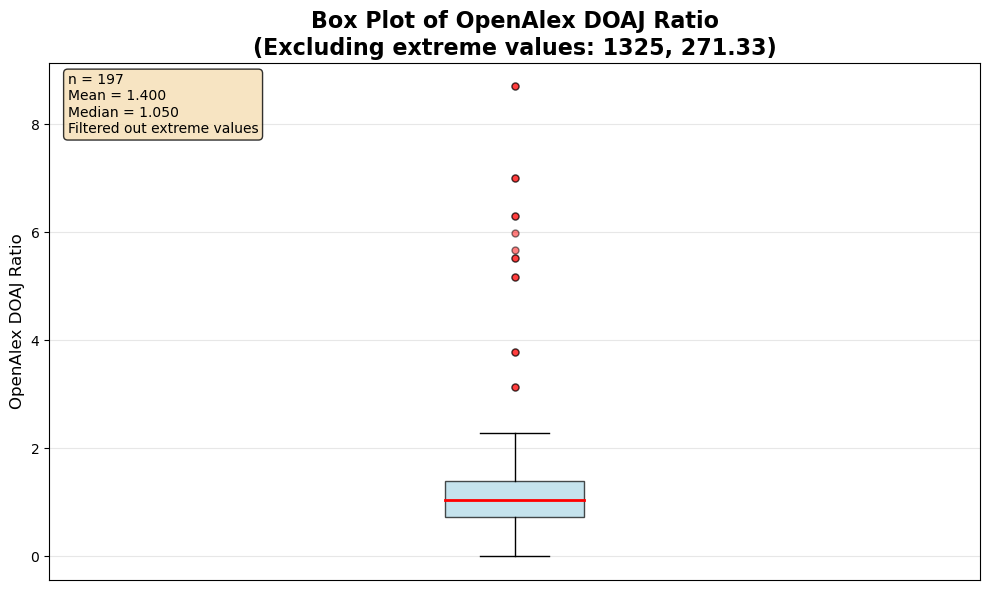

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_boxplot(csv_file):
    """
    Create a box plot for the 'openalex_doaj_ratio' column from a CSV file.
    
    Parameters:
    csv_file (str): Path to the CSV file
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Check if the column exists
        if 'openalex_doaj_ratio' not in df.columns:
            print(f"Error: Column 'openalex_doaj_ratio' not found in the CSV file.")
            print(f"Available columns: {list(df.columns)}")
            return
        
        # Get the column data and remove any NaN values
        data = df['openalex_doaj_ratio'].dropna()
        
        if len(data) == 0:
            print("Error: No valid data found in 'openalex_doaj_ratio' column.")
            return
        
        # Print original data info
        print(f"Original data count: {len(data)}")
        print(f"Original data range: {data.min():.4f} to {data.max():.4f}")
        
        # Filter out extreme values (1325 and 271.33)
        extreme_values = [1325, 271.33, 15.17, 13.31]
        original_count = len(data)
        data = data[~data.isin(extreme_values)]
        filtered_count = len(data)
        
        print(f"Filtered out {original_count - filtered_count} extreme values: {extreme_values}")
        print(f"Remaining data count: {filtered_count}")
        
        if len(data) == 0:
            print("Error: No data remaining after filtering extreme values.")
            return
        
        # Print some basic statistics
        print(f"Data summary for 'openalex_doaj_ratio':")
        print(f"Count: {len(data)}")
        print(f"Mean: {data.mean():.4f}")
        print(f"Median: {data.median():.4f}")
        print(f"Min: {data.min():.4f}")
        print(f"Max: {data.max():.4f}")
        print(f"Standard deviation: {data.std():.4f}")
        print()
        
        # Create the figure and axis
        plt.figure(figsize=(10, 6))
        
        # Create box plot using seaborn for better aesthetics
        box_plot = plt.boxplot(data, 
                              patch_artist=True,
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2),
                              flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
        
        # Customize the plot
        plt.title('Box Plot of OpenAlex DOAJ Ratio\n(Excluding extreme values: 1325, 271.33)', 
                 fontsize=16, fontweight='bold')
        plt.ylabel('OpenAlex DOAJ Ratio', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add some statistics as text on the plot
        stats_text = f'n = {len(data)}\nMean = {data.mean():.3f}\nMedian = {data.median():.3f}\nFiltered out extreme values'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Remove x-axis ticks since we only have one box
        plt.xticks([])
        
        # Adjust layout and show
        plt.tight_layout()
        plt.show()
        
        # Optional: Save the plot
        # plt.savefig('openalex_doaj_ratio_boxplot.png', dpi=300, bbox_inches='tight')
        
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found. Please check the file path.")
    except Exception as e:
        print(f"Error: {str(e)}")

# Main execution
if __name__ == "__main__":
    # Specify your CSV file path
    csv_file_path = 'openalex_coverage_report_20250828_214617.csv'
    
    # Create the box plot
    create_boxplot(csv_file_path)

# Natural Language Processing

Because of many journals providing tittles and abstract in English, terms have been extracted in both languages and then homologated (manually). 





## ECONOMICS-journal_lang-ES.db
1. Terms Extraction (150 terms) in English
2. Terms Extraction (150 terms) in Spanish
3. Curation (deleting bad descriptors), disambiguation / merging terms (Language Specific)
4. Merging of dictionaries of terms (under spanish terms)

Pigeon + Chi2 - ENG/SPA

`ENGIN_All--KW-TIT-ABS-Consolidated.csv`


## ENGINEERING-journal_lang-ES.db
1. Terms Extraction (150 terms) in English
2. Terms Extraction (150 terms) in Spanish
3. Curation (deleting bad descriptors), disambiguation / merging terms (Language Specific)
4. Merging of dictionaries of terms (under spanish terms)

Pigeon + Chi2 - ENG/SPA

`ECON_All--KW-TIT-ABS-Consolidated.csv`

## Comparing Early Results

In [88]:
import pandas as pd
import os

def load_data(file_path):
    """Loads a TSV file into a pandas DataFrame."""
    try:
        return pd.read_csv(file_path, sep='\t')
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
        return None

def create_key(row, columns):
    """Creates a unique key from a row's specified columns."""
    return tuple(row[col] for col in columns)

def compare_files(file1_path, file2_path, columns_to_compare):
    """
    Compares two TSV files for similarities and differences based on a set of columns.
    
    Args:
        file1_path (str): The path to the first TSV file.
        file2_path (str): The path to the second TSV file.
        columns_to_compare (list): A list of column names to use for comparison.
        
    Returns:
        A tuple containing:
        - A list of rows that are identical in both files.
        - A list of rows unique to the first file.
        - A list of rows unique to the second file.
    """
    df1 = load_data(file1_path)
    df2 = load_data(file2_path)

    if df1 is None or df2 is None:
        return [], [], []

    # Ensure the comparison columns exist in both DataFrames
    missing_cols_df1 = [col for col in columns_to_compare if col not in df1.columns]
    missing_cols_df2 = [col for col in columns_to_compare if col not in df2.columns]
    
    if missing_cols_df1 or missing_cols_df2:
        if missing_cols_df1:
            print(f"Error: Columns {missing_cols_df1} not found in {os.path.basename(file1_path)}")
        if missing_cols_df2:
            print(f"Error: Columns {missing_cols_df2} not found in {os.path.basename(file2_path)}")
        return [], [], []

    # Create sets of unique keys for efficient comparison
    keys1 = set(df1.apply(lambda row: create_key(row, columns_to_compare), axis=1))
    keys2 = set(df2.apply(lambda row: create_key(row, columns_to_compare), axis=1))

    # Find similarities (intersection) and differences
    similar_keys = keys1.intersection(keys2)
    unique_to_file1 = keys1.difference(keys2)
    unique_to_file2 = keys2.difference(keys1)

    # Filter DataFrames to get the corresponding rows
    similar_rows = df1[df1.apply(lambda row: create_key(row, columns_to_compare) in similar_keys, axis=1)].reset_index(drop=True)
    unique_rows1 = df1[df1.apply(lambda row: create_key(row, columns_to_compare) in unique_to_file1, axis=1)].reset_index(drop=True)
    unique_rows2 = df2[df2.apply(lambda row: create_key(row, columns_to_compare) in unique_to_file2, axis=1)].reset_index(drop=True)
    
    return similar_rows, unique_rows1, unique_rows2

def main():
    """Main function to run the comparison."""
    
    # Define your pairs of files and the columns to compare
    pairs = [
        ('ENGIN_Chi2_300--ENG.tsv', 'ENGIN_Chi2_300--ESP.tsv'),
    ]
    columns_to_compare = ['Stem', 'Main form', 'Forms']

    for file1, file2 in pairs:
        print(f"🔬 Analyzing pair: {file1} and {file2}")
        
        similar, unique1, unique2 = compare_files(file1, file2, columns_to_compare)
        
        if not all([isinstance(similar, pd.DataFrame), isinstance(unique1, pd.DataFrame), isinstance(unique2, pd.DataFrame)]):
            continue  # Skip to the next pair if an error occurred

        # Print summary statistics
        print(f"  - Common entries: {len(similar):,} found.")
        print(f"  - Entries unique to {file1}: {len(unique1):,} found.")
        print(f"  - Entries unique to {file2}: {len(unique2):,} found.")
        
        # Save results to new files
        pair_prefix = f"{os.path.basename(file1).replace('.tsv', '')}_{os.path.basename(file2).replace('.tsv', '')}"
        
        similar_file = f"similarities_{pair_prefix}.tsv"
        unique1_file = f"unique_to_{os.path.basename(file1)}"
        unique2_file = f"unique_to_{os.path.basename(file2)}"
        
        similar.to_csv(similar_file, sep='\t', index=False)
        unique1.to_csv(unique1_file, sep='\t', index=False)
        unique2.to_csv(unique2_file, sep='\t', index=False)
        
        print(f"  ✅ Results saved:")
        print(f"    - Similar entries: {similar_file}")
        print(f"    - Differences ({file1}): {unique1_file}")
        print(f"    - Differences ({file2}): {unique2_file}")
        print("-" * 50)

if __name__ == "__main__":
    main()

🔬 Analyzing pair: ENGIN_Chi2_300--ENG.tsv and ENGIN_Chi2_300--ESP.tsv
  - Common entries: 0 found.
  - Entries unique to ENGIN_Chi2_300--ENG.tsv: 100 found.
  - Entries unique to ENGIN_Chi2_300--ESP.tsv: 300 found.
  ✅ Results saved:
    - Similar entries: similarities_ENGIN_Chi2_300--ENG_ENGIN_Chi2_300--ESP.tsv
    - Differences (ENGIN_Chi2_300--ENG.tsv): unique_to_ENGIN_Chi2_300--ENG.tsv
    - Differences (ENGIN_Chi2_300--ESP.tsv): unique_to_ENGIN_Chi2_300--ESP.tsv
--------------------------------------------------


# Descriptive Statistics of the Corpus

`filtered_co_lang_engineering_records.tsv`
`filtered_co_lang_economics_records.tsv`

for two .csv with the same structure

author_affiliation (number of distinct affiliations; top 25)
author_name (number of distict authors; top 10, and the number of mentions)
journal_country (number of total journal countries; top 10, and number of occurrences)
journal_publisher (number of total journal publishers; top 25, and number of occurrences)
journal_title (number of journal tittles; top 25, and number of occurrences)
year (spread of documents over the years)
ISIpubdate (spread of documents over the dates)

In [90]:
#!/usr/bin/env python3
"""
Comprehensive Descriptive Statistics Analysis for Engineering and Economics TSV Files
Analyzes filtered DOAJ records with detailed statistics and visualizations
"""

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from datetime import datetime

# Set matplotlib to use SVG backend for vector graphics
plt.rcParams['svg.fonttype'] = 'none' # Ensure fonts are preserved as text

def load_and_validate_data(filename):
    """Load TSV file and validate structure."""
    if not os.path.exists(filename):
        print(f"Warning: File {filename} not found")
        return None, None
    
    try:
        df = pd.read_csv(filename, sep='\t', dtype=str)
        discipline = filename.split('_')[2] if 'engineering' in filename or 'economics' in filename else 'unknown'
        print(f"Loaded {filename}: {len(df)} records ({discipline})")
        return df, discipline
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, None

def clean_and_split_values(series, separator='***'):
    """Clean and split multi-value fields, return individual values with N/A tracking."""
    all_values = []
    na_count = 0
    
    for value in series:
        if pd.isna(value) or str(value).strip() == '' or str(value) == 'N/A':
            na_count += 1
        else:
            # Split by separator and clean each part
            parts = str(value).split(separator)
            for part in parts:
                cleaned = part.strip()
                if cleaned:
                    all_values.append(cleaned)
    
    return all_values, na_count

def analyze_field_statistics(df, field_name, top_n, separator='***', discipline=''):
    """Analyze statistics for a given field and export results."""
    print(f"\n=== {field_name.upper()} ANALYSIS ({discipline.upper()}) ===")
    
    if field_name not in df.columns:
        print(f"Field {field_name} not found in dataset")
        return None
    
    # Get all individual values and N/A count
    all_values, na_count = clean_and_split_values(df[field_name], separator)
    
    if not all_values and na_count == 0:
        print(f"No data found for {field_name}")
        return None
    
    # Count occurrences
    value_counts = Counter(all_values)
    total_entries = sum(value_counts.values())
    
    print(f"Total distinct {field_name}: {len(value_counts)}")
    print(f"Total valid entries: {total_entries}")
    print(f"N/A entries: {na_count}")
    print(f"Total records: {len(df)}")
    
    print(f"\nTop {top_n} {field_name}:")
    results_data = []
    
    for i, (value, count) in enumerate(value_counts.most_common(top_n), 1):
        percentage = (count / len(df)) * 100
        print(f"  {i:2d}. {value:<60} : {count:4d} ({percentage:5.1f}%)")
        results_data.append({
            'Rank': i,
            'Value': value,
            'Count': count,
            'Percentage': round(percentage, 1),
            'Field': field_name,
            'Discipline': discipline
        })
    
    # Add N/A information at the end
    if na_count > 0:
        na_percentage = (na_count / len(df)) * 100
        print(f"\n  N/A entries: {na_count} ({na_percentage:.1f}%)")
        results_data.append({
            'Rank': 'N/A',
            'Value': 'N/A',
            'Count': na_count,
            'Percentage': round(na_percentage, 1),
            'Field': field_name,
            'Discipline': discipline
        })
    
    # Export to CSV
    csv_filename = f"{discipline}_{field_name}_statistics.csv"
    results_df = pd.DataFrame(results_data)
    results_df.to_csv(csv_filename, index=False)
    print(f"Results exported to: {csv_filename}")
    
    return value_counts, na_count

def analyze_author_productivity(df, discipline=''):
    """Analyze author productivity (publications per author)."""
    print(f"\n=== AUTHOR PRODUCTIVITY ANALYSIS ({discipline.upper()}) ===")
    
    all_authors, na_count = clean_and_split_values(df['author_nam'])
    
    if not all_authors:
        print("No author data found")
        return None
    
    author_counts = Counter(all_authors)
    total_authors = len(author_counts)
    total_authorships = sum(author_counts.values())
    
    print(f"Total distinct authors: {total_authors}")
    print(f"Total author mentions: {total_authorships}")
    print(f"Average publications per author: {total_authorships/total_authors:.2f}")
    
    print(f"\nMost prolific authors (Top 15):")
    prolific_data = []
    
    for i, (author, pub_count) in enumerate(author_counts.most_common(15), 1):
        print(f"  {i:2d}. {author:<50} : {pub_count} publications")
        prolific_data.append({
            'Rank': i,
            'Author': author,
            'Publications': pub_count,
            'Discipline': discipline
        })
    
    # Export productivity data
    csv_filename = f"{discipline}_author_productivity.csv"
    prolific_df = pd.DataFrame(prolific_data)
    prolific_df.to_csv(csv_filename, index=False)
    print(f"Author productivity exported to: {csv_filename}")
    
    return author_counts

def analyze_temporal_data_comprehensive(df, field_name, discipline=''):
    """Comprehensive temporal analysis: basic, advanced, and comparative."""
    print(f"\n=== {field_name.upper()} TEMPORAL ANALYSIS ({discipline.upper()}) ===")
    
    if field_name not in df.columns:
        print(f"Field {field_name} not found in dataset")
        return None
    
    # Clean year data
    valid_years = []
    na_count = 0
    
    for year_val in df[field_name]:
        if pd.isna(year_val) or str(year_val).strip() == '' or str(year_val) == 'N/A':
            na_count += 1
        else:
            try:
                year_str = str(year_val).strip()
                if len(year_str) == 4 and year_str.isdigit():
                    year = int(year_str)
                    if 1900 <= year <= 2030:
                        valid_years.append(year)
            except:
                na_count += 1
    
    if not valid_years:
        print(f"No valid years found for {field_name}")
        return None
    
    year_counts = Counter(valid_years)
    
    # Basic statistics
    print(f"BASIC TEMPORAL STATISTICS:")
    print(f"Year range: {min(valid_years)} - {max(valid_years)}")
    print(f"Total records with valid years: {len(valid_years)}")
    print(f"Distinct years: {len(year_counts)}")
    print(f"N/A entries: {na_count}")
    
    # Advanced statistics
    print(f"\nADVANCED TEMPORAL ANALYSIS:")
    years_array = np.array(valid_years)
    print(f"Mean year: {np.mean(years_array):.1f}")
    print(f"Median year: {np.median(years_array):.1f}")
    print(f"Standard deviation: {np.std(years_array):.2f}")
    
    # Trend analysis using linear regression
    unique_years = sorted(year_counts.keys())
    yearly_counts = [year_counts[year] for year in unique_years]
    
    if len(unique_years) > 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(unique_years, yearly_counts)
        print(f"Linear trend slope: {slope:.3f} publications/year")
        print(f"R-squared: {r_value**2:.3f}")
        print(f"Trend significance (p-value): {p_value:.4f}")
    
    # Show year distribution
    print(f"\nYEAR DISTRIBUTION (All years with counts):")
    temporal_data = []
    
    for year in sorted(year_counts.keys()):
        count = year_counts[year]
        percentage = (count / len(valid_years)) * 100
        print(f"  {year}: {count:4d} records ({percentage:5.1f}%)")
        temporal_data.append({
            'Year': year,
            'Count': count,
            'Percentage': round(percentage, 1),
            'Discipline': discipline,
            'Field': field_name
        })
    
    # Add N/A information
    if na_count > 0:
        na_percentage = (na_count / len(df)) * 100
        print(f"\n  N/A entries: {na_count} ({na_percentage:.1f}%)")
        temporal_data.append({
            'Year': 'N/A',
            'Count': na_count,
            'Percentage': round(na_percentage, 1),
            'Discipline': discipline,
            'Field': field_name
        })
    
    # Export temporal data
    csv_filename = f"{discipline}_{field_name}_temporal_analysis.csv"
    temporal_df = pd.DataFrame(temporal_data)
    temporal_df.to_csv(csv_filename, index=False)
    print(f"Temporal analysis exported to: {csv_filename}")
    
    return year_counts, valid_years

def create_individual_visualizations(data_dict, analysis_type, disciplines):
    """Create separate SVG visualizations for each analysis type."""
    
    if analysis_type == 'affiliations':
        # Author affiliations visualization
        fig, axes = plt.subplots(1, len(disciplines), figsize=(12*len(disciplines), 8))
        if len(disciplines) == 1:
            axes = [axes]
        
        for i, (discipline, df) in enumerate(disciplines.items()):
            if discipline in data_dict:
                affiliations, na_count = clean_and_split_values(df['author_aff'])
                affil_counts = Counter(affiliations)
                top_affiliations = dict(affil_counts.most_common(15))
                
                y_pos = np.arange(len(top_affiliations))
                axes[i].barh(y_pos, list(top_affiliations.values()), alpha=0.8)
                axes[i].set_yticks(y_pos)
                axes[i].set_yticklabels([k[:40] + '...' if len(k) > 40 else k
                                         for k in top_affiliations.keys()], fontsize=10)
                axes[i].set_xlabel('Number of Authors')
                axes[i].set_title(f'Top 15 Author Affiliations - {discipline.title()}')
                axes[i].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('author_affiliations_analysis.svg', format='svg', bbox_inches='tight')
        plt.close()
    
    elif analysis_type == 'countries':
        # Journal countries visualization
        fig, axes = plt.subplots(1, len(disciplines), figsize=(10*len(disciplines), 6))
        if len(disciplines) == 1:
            axes = [axes]
        
        for i, (discipline, df) in enumerate(disciplines.items()):
            countries, na_count = clean_and_split_values(df['journal_co'])
            country_counts = Counter(countries)
            top_countries = dict(country_counts.most_common(10))
            
            axes[i].bar(range(len(top_countries)), list(top_countries.values()), alpha=0.8)
            axes[i].set_xticks(range(len(top_countries)))
            axes[i].set_xticklabels(list(top_countries.keys()), rotation=45, ha='right')
            axes[i].set_ylabel('Number of Records')
            axes[i].set_title(f'Top 10 Journal Countries - {discipline.title()}')
            axes[i].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('journal_countries_analysis.svg', format='svg', bbox_inches='tight')
        plt.close()
    
    elif analysis_type == 'publishers':
        # Journal publishers visualization
        fig, axes = plt.subplots(len(disciplines), 1, figsize=(16, 8*len(disciplines)))
        if len(disciplines) == 1:
            axes = [axes]
        
        for i, (discipline, df) in enumerate(disciplines.items()):
            publishers, na_count = clean_and_split_values(df['journal_pu'])
            pub_counts = Counter(publishers)
            top_pubs = dict(pub_counts.most_common(20))
            
            y_pos = np.arange(len(top_pubs))
            axes[i].barh(y_pos, list(top_pubs.values()), alpha=0.8)
            axes[i].set_yticks(y_pos)
            axes[i].set_yticklabels([k[:50] + '...' if len(k) > 50 else k
                                     for k in top_pubs.keys()], fontsize=9)
            axes[i].set_xlabel('Number of Records')
            axes[i].set_title(f'Top 20 Publishers - {discipline.title()}')
            axes[i].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('journal_publishers_analysis.svg', format='svg', bbox_inches='tight')
        plt.close()

def create_temporal_visualizations(temporal_data, disciplines):
    """Create comprehensive temporal analysis visualizations."""
    
    # 1. Basic temporal distribution
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    for discipline, year_data in temporal_data.items():
        if year_data:
            year_counts, valid_years = year_data
            unique_years = sorted(year_counts.keys())
            yearly_counts = [year_counts[year] for year in unique_years]
            
            axes[0].plot(unique_years, yearly_counts, marker='o', linewidth=2,
                         label=discipline.title(), alpha=0.8)
    
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Publications')
    axes[0].set_title('Publication Trends Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Cumulative publications
    for discipline, year_data in temporal_data.items():
        if year_data:
            year_counts, valid_years = year_data
            unique_years = sorted(year_counts.keys())
            yearly_counts = [year_counts[year] for year in unique_years]
            cumulative = np.cumsum(yearly_counts)
            
            axes[1].plot(unique_years, cumulative, marker='s', linewidth=2,
                         label=discipline.title(), alpha=0.8)
    
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Cumulative Publications')
    axes[1].set_title('Cumulative Publications Over Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('temporal_basic_analysis.svg', format='svg', bbox_inches='tight')
    plt.close()
    
    # 3. Advanced temporal analysis with moving averages
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    for discipline, year_data in temporal_data.items():
        if year_data:
            year_counts, valid_years = year_data
            unique_years = sorted(year_counts.keys())
            yearly_counts = [year_counts[year] for year in unique_years]
            
            # Original data
            axes[0].plot(unique_years, yearly_counts, 'o-', alpha=0.6,
                         label=f'{discipline.title()} (Raw)')
            
            # 3-year moving average
            if len(yearly_counts) >= 3:
                moving_avg = pd.Series(yearly_counts).rolling(window=3, center=True).mean()
                axes[0].plot(unique_years, moving_avg, linewidth=3,
                             label=f'{discipline.title()} (3-year avg)')
    
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Publications')
    axes[0].set_title('Publication Trends with Moving Averages')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Year-over-year growth rates
    for discipline, year_data in temporal_data.items():
        if year_data:
            year_counts, valid_years = year_data
            unique_years = sorted(year_counts.keys())
            yearly_counts = [year_counts[year] for year in unique_years]
            
            if len(yearly_counts) > 1:
                growth_rates = []
                growth_years = []
                for i in range(1, len(yearly_counts)):
                    if yearly_counts[i-1] > 0:
                        growth_rate = ((yearly_counts[i] - yearly_counts[i-1]) / yearly_counts[i-1]) * 100
                        growth_rates.append(growth_rate)
                        growth_years.append(unique_years[i])
                
                if growth_rates:
                    axes[1].plot(growth_years, growth_rates, 'o-', alpha=0.8,
                                 label=discipline.title())
    
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Growth Rate (%)')
    axes[1].set_title('Year-over-Year Publication Growth Rates')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('temporal_advanced_analysis.svg', format='svg', bbox_inches='tight')
    plt.close()

def create_comparative_analysis(engineering_df, economics_df):
    """Create comparative analysis between disciplines."""
    
    if engineering_df is None or economics_df is None:
        print("Cannot create comparative analysis - missing data for one or both disciplines")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Publication volume comparison
    eng_years = []
    eco_years = []
    
    for year_val in engineering_df['year'].dropna():
        try:
            year = int(str(year_val).strip())
            if 1990 <= year <= 2025:
                eng_years.append(year)
        except:
            continue
    
    for year_val in economics_df['year'].dropna():
        try:
            year = int(str(year_val).strip())
            if 1990 <= year <= 2025:
                eco_years.append(year)
        except:
            continue
    
    all_years = sorted(set(eng_years + eco_years))
    eng_counts = [eng_years.count(year) for year in all_years]
    eco_counts = [eco_years.count(year) for year in all_years]
    
    width = 0.35
    x = np.arange(len(all_years))
    axes[0,0].bar(x - width/2, eng_counts, width, label='Engineering', alpha=0.8)
    axes[0,0].bar(x + width/2, eco_counts, width, label='Economics', alpha=0.8)
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Number of Publications')
    axes[0,0].set_title('Publication Volume by Discipline')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(all_years, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. Language distribution comparison
    # This section has been removed as per your request.
    axes[0,1].set_visible(False) # Hide the subplot to maintain layout
    
    # 3. Country distribution comparison (top 10)
    eng_countries, _ = clean_and_split_values(engineering_df['journal_co'])
    eco_countries, _ = clean_and_split_values(economics_df['journal_co'])
    
    eng_country_counts = Counter(eng_countries)
    eco_country_counts = Counter(eco_countries)
    
    top_countries = set(dict(eng_country_counts.most_common(10)).keys()) | \
                    set(dict(eco_country_counts.most_common(10)).keys())
    
    top_countries = sorted(top_countries)
    eng_counts = [eng_country_counts.get(country, 0) for country in top_countries]
    eco_counts = [eco_country_counts.get(country, 0) for country in top_countries]
    
    x = np.arange(len(top_countries))
    axes[1,0].bar(x - width/2, eng_counts, width, label='Engineering', alpha=0.8)
    axes[1,0].bar(x + width/2, eco_counts, width, label='Economics', alpha=0.8)
    axes[1,0].set_xlabel('Country')
    axes[1,0].set_ylabel('Number of Records')
    axes[1,0].set_title('Country Distribution by Discipline (Top Countries)')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(top_countries, rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # 4. Dataset size comparison
    sizes = [len(engineering_df), len(economics_df)]
    labels = ['Engineering', 'Economics']
    colors = ['skyblue', 'lightcoral']
    
    axes[1,1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Dataset Size Distribution')
    
    plt.tight_layout()
    plt.savefig('comparative_analysis.svg', format='svg', bbox_inches='tight')
    plt.close()

def generate_comprehensive_summary(engineering_data, economics_data):
    """Generate comprehensive summary with all statistics."""
    print("\n" + "="*100)
    print("COMPREHENSIVE DOAJ RECORDS ANALYSIS SUMMARY")
    print("="*100)
    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Analysis completed: {timestamp}")
    
    summary_data = []
    
    for discipline, df in [("Engineering", engineering_data[0]), ("Economics", economics_data[0])]:
        if df is None:
            continue
            
        print(f"\n{discipline.upper()} DISCIPLINE COMPREHENSIVE SUMMARY:")
        print("-" * 60)
        
        # Basic statistics
        total_records = len(df)
        print(f"Total records: {total_records:,}")
        
        # Detailed field analysis
        fields_analysis = {
            'Authors': clean_and_split_values(df['author_nam']),
            'Affiliations': clean_and_split_values(df['author_aff']),
            'Countries': clean_and_split_values(df['journal_co']),
            'Publishers': clean_and_split_values(df['journal_pu']),
            'Journals': clean_and_split_values(df['journal_ti']),
        }
        
        for field_name, (values, na_count) in fields_analysis.items():
            distinct_count = len(set(values))
            total_values = len(values)
            print(f"{field_name}:")
            print(f"  - Distinct {field_name.lower()}: {distinct_count:,}")
            print(f"  - Total entries: {total_values:,}")
            print(f"  - N/A entries: {na_count:,}")
            if total_values + na_count > 0:
                completeness = (total_values / (total_values + na_count)) * 100
                print(f"  - Data completeness: {completeness:.1f}%")
            
            summary_data.append({
                'Discipline': discipline,
                'Field': field_name,
                'Distinct_Count': distinct_count,
                'Total_Entries': total_values,
                'NA_Count': na_count,
                'Completeness_Percent': round(completeness, 1) if total_values + na_count > 0 else 0
            })
        
        # Temporal analysis summary
        years = []
        for year_val in df['year'].dropna():
            try:
                year = int(str(year_val).strip())
                if 1900 <= year <= 2030:
                    years.append(year)
            except:
                continue
        
        if years:
            print(f"\nTemporal Coverage:")
            print(f"  - Year range: {min(years)} - {max(years)}")
            print(f"  - Records with valid years: {len(years):,}")
            print(f"  - Average year: {np.mean(years):.1f}")
    
    # Export summary data
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('comprehensive_summary_statistics.csv', index=False)
    print(f"\nComprehensive summary exported to: comprehensive_summary_statistics.csv")

def main():
    """Main comprehensive analysis function."""
    print("DOAJ Records Comprehensive Descriptive Statistics Analysis")
    print("=" * 70)
    
    # Load datasets
    engineering_data = load_and_validate_data('filtered_co_lang_engineering_records.tsv')
    economics_data = load_and_validate_data('filtered_co_lang_economics_records.tsv')
    
    if engineering_data[0] is None and economics_data[0] is None:
        print("No valid datasets found. Please check file names and paths.")
        return
    
    datasets = {}
    temporal_results = {}
    
    # Analyze each dataset
    for data_tuple in [engineering_data, economics_data]:
        df, discipline = data_tuple
        if df is None:
            continue
            
        datasets[discipline] = df
        
        print(f"\n{'='*25} {discipline.upper()} ANALYSIS {'='*25}")
        
        # Statistical analyses with exports
        analyze_field_statistics(df, 'author_aff', 25, '***', discipline)
        analyze_field_statistics(df, 'author_nam', 10, '***', discipline)
        analyze_author_productivity(df, discipline)
        analyze_field_statistics(df, 'journal_co', 10, '***', discipline)
        analyze_field_statistics(df, 'journal_pu', 25, '***', discipline)
        analyze_field_statistics(df, 'journal_ti', 25, '***', discipline)
        
        # Comprehensive temporal analyses
        year_results = analyze_temporal_data_comprehensive(df, 'year', discipline)
        isi_results = analyze_temporal_data_comprehensive(df, 'Time Steps', discipline)
        
        if year_results:
            temporal_results[discipline] = year_results
    
    # Create individual visualizations
    print(f"\n{'='*25} GENERATING VISUALIZATIONS {'='*25}")
    
    if datasets:
        create_individual_visualizations(datasets, 'affiliations', datasets)
        create_individual_visualizations(datasets, 'countries', datasets)
        create_individual_visualizations(datasets, 'publishers', datasets)
        
        if temporal_results:
            create_temporal_visualizations(temporal_results, datasets)
        
        # Comparative analysis if both datasets exist
        if 'engineering' in datasets and 'economics' in datasets:
            create_comparative_analysis(datasets['engineering'], datasets['economics'])
    
    # Generate comprehensive summary
    generate_comprehensive_summary(engineering_data, economics_data)
    
    print(f"\n{'='*25} ANALYSIS COMPLETE {'='*25}")
    print("Generated files:")
    print("- Individual CSV files for each analysis")
    print("- SVG visualizations for each analysis type")
    print("- comprehensive_summary_statistics.csv")
    print("\nAll visualizations saved as SVG vector graphics")

if __name__ == "__main__":
    main()

DOAJ Records Comprehensive Descriptive Statistics Analysis
Loaded filtered_co_lang_engineering_records.tsv: 13140 records (lang)
Loaded filtered_co_lang_economics_records.tsv: 16810 records (lang)

========================= LANG ANALYSIS =========================

=== AUTHOR_AFF ANALYSIS (LANG) ===
Total distinct author_aff: 7774
Total valid entries: 28150
N/A entries: 2720
Total records: 13140

Top 25 author_aff:
   1. Universidad Distrital Francisco José de Caldas               : 1146 (  8.7%)
   2. Universidad Industrial de Santander                          :  862 (  6.6%)
   3. Universidad Nacional de Colombia                             :  651 (  5.0%)
   4. Universidad Nacional Mayor de San Marcos. Lima, Perú         :  623 (  4.7%)
   5. Universidad San Francisco de Quito                           :  363 (  2.8%)
   6. Universidad de Antioquia                                     :  347 (  2.6%)
   7. Universidad del Valle                                        :  339 (  2.6%)
 

# Network Analysis and Visualization


1. [Economy](https://retina.cortext.net/#/graph/?url=https%3A%2F%2Fassets.cortext.net%2Fdocs%2F24324733a21c0e259951232e808ff1ae&sa[]=w&sa[]=i&sa[]=o&sa[]=re&sa[]=be&ca=cll&st[]=w&st[]=i&st[]=o&st[]=cll&st[]=re&st[]=be&lt=1.974&ls=10&le=22)
2. [Engineering](https://retina.cortext.net/#/graph/?url=https%3A%2F%2Fassets.cortext.net%2Fdocs%2Fc936161de2236fd2276951735f4578b4&sa[]=w&sa[]=i&sa[]=o&sa[]=re&sa[]=be&ca=cll&st[]=w&st[]=i&st[]=o&st[]=cll&st[]=re&st[]=be&lt=1.974&ls=10&le=22)


## Cluster Tables

In [10]:
import pandas as pd
from collections import OrderedDict

def process_csv_to_markdown():
    """
    Process 4 CSV files containing network cluster data and generate separate markdown tables.
    """
    
    # Define file mappings
    files_config = {
        'ECON_ESP_clusters.csv': {'prefix': 'Ec_SP', 'title': 'Economic Spanish Network'},
        'ECON_ENG_clusters.csv': {'prefix': 'Ec_EN', 'title': 'Economic English Network'},
        'ENGIN_ESP_clusters.csv': {'prefix': 'En_SP', 'title': 'Engineering Spanish Network'},
        'ENGIN_ENG_clusters.csv': {'prefix': 'En_EN', 'title': 'Engineering English Network'}
    }
    
    # Store all network tables
    all_tables = {}
    
    # Process each file
    for filename, config in files_config.items():
        try:
            # Read CSV file (tab-separated)
            df = pd.read_csv(filename, sep='\t')
            
            # Debug: Print column names
            print(f"Column names in {filename}: {list(df.columns)}")
            
            # Clean column names (remove extra spaces and convert to lowercase)
            df.columns = df.columns.str.strip().str.lower()
            print(f"Cleaned column names: {list(df.columns)}")
            
            # Group by cluster name (data column)
            clusters = OrderedDict()
            
            for _, row in df.iterrows():
                cluster_name = row['data']
                term = row['term']
                density = row['density']
                
                if cluster_name not in clusters:
                    clusters[cluster_name] = {
                        'terms': [],
                        'density': density
                    }
                
                clusters[cluster_name]['terms'].append(term)
            
            # Process each cluster for this file
            network_clusters = []
            cluster_num = 1
            for cluster_name, cluster_data in clusters.items():
                # Create cluster label with actual cluster name
                cluster_label = f"{cluster_name} *({config['prefix']}_{cluster_num})*"
                
                # Get first 10 terms
                terms = cluster_data['terms'][:10]
                
                # Add "..." if cluster has more than 15 terms
                if len(cluster_data['terms']) > 15:
                    terms_str = ", ".join(terms) + ", ..."
                else:
                    terms_str = ", ".join(terms)
                
                # Format density in italics
                density_str = f"*{cluster_data['density']}*"
                
                # Add to network clusters
                network_clusters.append({
                    'semantic_cluster': cluster_label,
                    'terms': terms_str,
                    'density': density_str
                })
                
                cluster_num += 1
            
            # Generate markdown table for this network
            if network_clusters:
                table_markdown = generate_markdown_table(network_clusters, config['title'])
                all_tables[filename] = table_markdown
                
        except FileNotFoundError:
            print(f"Warning: File {filename} not found. Skipping...")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return all_tables

def generate_markdown_table(clusters, title):
    """
    Generate markdown table from processed cluster data with a title.
    """
    if not clusters:
        return "No data to process."
    
    # Create table with title
    markdown = f"## {title}\n\n"
    markdown += "| Semantic Cluster | Terms | Density |\n"
    markdown += "|------------------|-------|----------|\n"
    
    # Add each cluster row
    for cluster in clusters:
        markdown += f"| {cluster['semantic_cluster']} | {cluster['terms']} | {cluster['density']} |\n"
    
    markdown += "\n"
    
    return markdown

def save_markdown_tables(all_tables, output_filename="network_clusters_tables.md"):
    """
    Save all markdown tables to a .md file.
    """
    try:
        # Ensure the output filename has .md extension
        if not output_filename.endswith('.md'):
            output_filename += '.md'
            
        with open(output_filename, 'w', encoding='utf-8') as f:
            for filename, table_content in all_tables.items():
                f.write(table_content)
        print(f"All markdown tables saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving file: {str(e)}")

# Main execution
if __name__ == "__main__":
    print("Processing CSV files to generate markdown tables...")
    
    # Generate markdown tables for each network
    all_tables = process_csv_to_markdown()
    
    # Print each table to console
    print("\nGenerated Markdown Tables:")
    print("=" * 50)
    for filename, table_content in all_tables.items():
        print(f"\nTable for {filename}:")
        print("-" * 30)
        print(table_content)
    
    # Save all tables to file
    save_markdown_tables(all_tables)
    
    print("\nProcessing complete!")

Processing CSV files to generate markdown tables...
Column names in ECON_ESP_clusters.csv: ['data', 'term', 'density']
Cleaned column names: ['data', 'term', 'density']
Column names in ECON_ENG_clusters.csv: ['data', 'term', 'density']
Cleaned column names: ['data', 'term', 'density']
Column names in ENGIN_ESP_clusters.csv: ['data', 'term', 'density']
Cleaned column names: ['data', 'term', 'density']
Column names in ENGIN_ENG_clusters.csv: ['data', 'term', 'density']
Cleaned column names: ['data', 'term', 'density']

Generated Markdown Tables:

Table for ECON_ESP_clusters.csv:
------------------------------
## Economic Spanish Network

| Semantic Cluster | Terms | Density |
|------------------|-------|----------|
| tipo de cambio & política monetaria *(Ec_SP_1)* | los rendimientos, mercado accionario, los precios, mercados financieros, los activos, historia económica, redes neuronales, Monte Carlo, las pruebas, banco central, ... | *0.853361509860909* |
| teoría económica & los economi

In [11]:
import re

def parse_markdown_file(filename="network_clusters_tables.md"):
    """
    Parse the markdown file containing network cluster tables.
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Split content by sections (## headers)
        sections = re.split(r'^## (.+)$', content, flags=re.MULTILINE)
        
        # Parse sections into structured data
        tables = {}
        for i in range(1, len(sections), 2):  # Skip first empty section
            if i + 1 < len(sections):
                title = sections[i].strip()
                table_content = sections[i + 1].strip()
                
                # Parse table rows
                rows = parse_markdown_table(table_content)
                if rows:
                    tables[title] = rows
        
        return tables
    
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return {}
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return {}

def parse_markdown_table(table_content):
    """
    Parse markdown table content into structured data.
    """
    lines = table_content.split('\n')
    rows = []
    
    # Find table lines (skip header separator line)
    for line in lines:
        line = line.strip()
        if line.startswith('|') and '---' not in line and 'Semantic Cluster' not in line:
            # Split by | and clean up
            cells = [cell.strip() for cell in line.split('|')[1:-1]]  # Remove empty first/last
            if len(cells) >= 3:  # Ensure we have all three columns
                rows.append({
                    'semantic_cluster': cells[0],
                    'terms': cells[1],
                    'density': cells[2]
                })
    
    return rows

def escape_latex_special_chars(text):
    """
    Escape special LaTeX characters in text.
    """
    # Common LaTeX special characters
    special_chars = {
        '&': '\\&',
        '%': '\\%',
        '$': '\\$',
        '#': '\\#',
        '^': '\\textasciicircum{}',
        '_': '\\_',
        '{': '\\{',
        '}': '\\}',
        '~': '\\textasciitilde{}',
        '\\': '\\textbackslash{}'
    }
    
    for char, replacement in special_chars.items():
        text = text.replace(char, replacement)
    
    return text

def convert_markdown_formatting_to_latex(text):
    """
    Convert markdown italic formatting to LaTeX.
    """
    # Convert *text* to \textit{text}
    text = re.sub(r'\*([^*]+)\*', r'\\textit{\1}', text)
    
    # Convert *(text)* to \textit{(text)}
    text = re.sub(r'\*\(([^)]+)\)\*', r'\\textit{(\1)}', text)
    
    return text

def generate_latex_table(title, rows):
    """
    Generate LaTeX table for a single network.
    """
    latex = f"""
\\begin{{table}}[htbp]
\\centering
\\caption{{{title}}}
\\begin{{tabular}}{{|p{{3cm}}|p{{8cm}}|p{{2cm}}|}}
\\hline
\\textbf{{Semantic Cluster}} & \\textbf{{Terms}} & \\textbf{{Density}} \\\\
\\hline
"""
    
    for row in rows:
        # Escape special characters and convert formatting
        cluster = convert_markdown_formatting_to_latex(escape_latex_special_chars(row['semantic_cluster']))
        terms = convert_markdown_formatting_to_latex(escape_latex_special_chars(row['terms']))
        density = convert_markdown_formatting_to_latex(escape_latex_special_chars(row['density']))
        
        latex += f"{cluster} & {terms} & {density} \\\\\n\\hline\n"
    
    latex += """\\end{tabular}
\\end{table}

"""
    
    return latex

def generate_all_latex_tables(tables):
    """
    Generate LaTeX code for all tables.
    """
    latex_document = """% LaTeX tables generated from markdown
% Add these packages to your document preamble:
% \\usepackage{array}
% \\usepackage{longtable} % if tables are very long

"""
    
    for title, rows in tables.items():
        latex_document += generate_latex_table(title, rows)
    
    return latex_document

def save_latex_file(latex_content, output_filename="network_clusters_tables.tex"):
    """
    Save LaTeX tables to a .tex file.
    """
    try:
        # Ensure the output filename has .tex extension
        if not output_filename.endswith('.tex'):
            output_filename += '.tex'
            
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(latex_content)
        print(f"LaTeX tables saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving LaTeX file: {str(e)}")

def create_complete_latex_document(tables, output_filename="network_clusters_document.tex"):
    """
    Create a complete LaTeX document with all tables.
    """
    document = """\\documentclass{article}
\\usepackage[utf8]{inputenc}
\\usepackage{array}
\\usepackage{longtable}
\\usepackage[margin=1in]{geometry}

\\title{Network Cluster Analysis Tables}
\\author{Generated from Markdown}
\\date{\\today}

\\begin{document}

\\maketitle

\\section{Network Cluster Tables}

"""
    
    for title, rows in tables.items():
        document += generate_latex_table(title, rows)
    
    document += """
\\end{document}
"""
    
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(document)
        print(f"Complete LaTeX document saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving complete LaTeX document: {str(e)}")

# Main execution
if __name__ == "__main__":
    print("Converting markdown tables to LaTeX format...")
    
    # Parse the markdown file
    tables = parse_markdown_file()
    
    if not tables:
        print("No tables found or error reading file.")
        exit(1)
    
    print(f"Found {len(tables)} tables:")
    for title in tables.keys():
        print(f"  - {title}")
    
    # Generate LaTeX tables only
    latex_tables = generate_all_latex_tables(tables)
    
    # Save just the tables
    save_latex_file(latex_tables)
    
    # Also create a complete LaTeX document
    create_complete_latex_document(tables)
    
    print("\nConversion complete!")
    print("Generated files:")
    print("  - network_clusters_tables.tex (tables only)")
    print("  - network_clusters_document.tex (complete document)")

Converting markdown tables to LaTeX format...
Found 4 tables:
  - Economic Spanish Network
  - Economic English Network
  - Engineering Spanish Network
  - Engineering English Network
LaTeX tables saved to: network_clusters_tables.tex
Complete LaTeX document saved to: network_clusters_document.tex

Conversion complete!
Generated files:
  - network_clusters_tables.tex (tables only)
  - network_clusters_document.tex (complete document)


## Generated Markdown Tables:

### Economic Spanish Network

| Semantic Cluster | Terms | Density |
|------------------|-------|----------|
| tipo de cambio & política monetaria *(Ec_SP_1)* | los rendimientos, mercado accionario, los precios, mercados financieros, los activos, historia económica, redes neuronales, Monte Carlo, las pruebas, banco central, ... | *0.853361509860909* |
| teoría económica & los economistas *(Ec_SP_2)* | Karl Marx, su obra, economic theory, pensamiento crítico, ser humano, equilibrio general, Adam Smith, Ciencias Económicas, análisis económico, tasa de ganancia, ... | *0.841884139165213* |
| las empresas & las organizaciones *(Ec_SP_3)* | satisfacción laboral, los costos, análisis de contenido, empresas colombianas, innovación tecnológica, las TIC, información financiera, los usuarios, recursos humanos, relación directa, ... | *0.82908914401773* |
| sector eléctrico & las tarifas *(Ec_SP_4)* | sector eléctrico, las tarifas, eficiencia económica, gas natural, energía eléctrica | *0.826225686320082* |
| fuerza laboral & mercado laboral *(Ec_SP_5)* | brecha salarial, unemployment rate, sector informal, países en desarrollo, per capita, informalidad laboral, salario real, América Latina, politicas públicas, international trade, ... | *0.798807382244268* |
| mercado interno & apertura comercial *(Ec_SP_6)* | las regiones, proceso de globalización, industria automotriz, sectores productivos, las remesas, análisis comparativo, mejor desempeño, ventajas comparativas, comercio exterior, comercio internacional, ... | *0.776496300248989* |
| medio ambiente & desarrollo sostenible *(Ec_SP_7)* | valoración contingente, impactos ambientales, cambio climático, turismo comunitario, las emisiones, las materias, cadena productiva, bienestar social, sector rural, tasa de descuento, ... | *0.75212728887843* |
| los individuos & los hogares *(Ec_SP_8)* | encuentra evidencia, los efectos, los ingresos, desempeño económico, las preferencias, las mujeres, crecimiento de la productividad, Santa Fe, política social, efecto negativo, ... | *0.668051437543791* |
| los Estados & los intereses *(Ec_SP_9)* | los intereses, La ley, últimas décadas, Colombia, las reformas, human rights, Costa Rica, fuentes primarias, crisis económica, El Salvador, ... | *0.639655639200987* |

### Economic English Network

| Semantic Cluster | Terms | Density |
|------------------|-------|----------|
| inflation target & exchange rate *(Ec_EN_1)* | exchange rate regime, foreign currency, output gap, energy sector, financial crisis, DSGE model, commodity prices, capital flows, inflation rate, open economy, ... | *0.943743744967315* |
| business models & private sector *(Ec_EN_2)* | agency theory, R and D, absorptive capacities, effective communication, COVID-19 crisis, environmental services, higher levels, Latin American, sustainable development goals, Latin American countries, ... | *0.834535988442917* |
| firm size & economic activity *(Ec_EN_3)* | natural gas, fuel subsidy, firm size, renewable energy, Colombian government, economic activity, energy resources, national governments, products and services, gross domestic product, ... | *0.652940415863605* |
| financial performance & institutional theory *(Ec_EN_4)* | state ownership, management systems, institutional theory, industrial policies, business groups, political connections, state-owned enterprises, CSR engagement, research and development, corporate strategies | *0.873798225984466* |
| different types & Foreign Direct Investment *(Ec_EN_5)* | wide range, Knowledge Region, case of Mexico, local firms, central america, environmental awareness, Social implications, knowledge transfer, host government, theoretical model, ... | *0.793672697269772* |
| services sector & manufacturing firms *(Ec_EN_6)* | innovation output, innovation management, positive effects, product innovation, bibliometric analysis, information technology, climate change, environmental impacts, data collection, labor productivity, ... | *0.871297029245068* |
| job creation & optimal fiscal policy *(Ec_EN_7)* | tax evasion, job creation, necessity entrepreneurship, Global Entrepreneurship Monitor, labor market, fiscal policy, same time, optimal fiscal policy | *0.873248332409028* |
| social development & medium enterprises *(Ec_EN_8)* | construction industry, corporate social responsibility, entrepreneurial ecosystems, social entrepreneurship, new approach, CSR practices, social development, higher education institutions, university students, regional development | *0.879436408190741* |


## Engineering Spanish Network

| Semantic Cluster | Terms | Density |
|------------------|-------|----------|
| microscopía electrónica & propiedades mecánicas *(En_SP_1)* | composición química, los efectos, tamaño de partícula, vida útil, velocidad de corrosión, compuestos bioactivos, modelo matemático, arco eléctrico, X-ray diffraction, Los análisis, ... | *0.846543957402665* |
| instituciones educativas & los estudiantes *(En_SP_2)* | satisfacción laboral, cultura de, grupos de investigación, innovación abierta, calidad de servicio, los docentes, ventaja competitiva, alfabetización digital, estrés académico, instituciones educativas, ... | *0.934506921000274* |
| cambio de uso & cambio climático *(En_SP_3)* | cambio de uso, temperatura mínima, cambio climático, modelización numérica, agua del suelo, del suelo, erosión hídrica, cobertura vegetal, información geográfica, uso de suelo, ... | *0.802020074871713* |
| redes neuronales & inteligencia artificial *(En_SP_4)* | estudio de factibilidad, inteligencia artificial, redes neuronales, grandes volúmenes, variables independientes, métodos convencionales, problema de localización, Support Vector Machines, energía solar, eficiencia energética, ... | *0.799358992178232* |
| energía renovable & distribution network *(En_SP_5)* | sistema de control, algoritmo de optimización, distribution systems, caídas de tensión, combustibles fósiles, responsabilidad social, control strategies, distribution network, genetic algorithms, time series, ... | *0.855787387010091* |
| agua & del agua *(En_SP_6)* | evaluación económica, aguas residuales domésticas, agua, diseño experimental, concentración inicial, agua subterránea, sulfato de aluminio, adultos mayores, las aguas, índice de calidad, ... | *0.841536492192839* |
| Recuperación mejorada de petróleo & petróleo pesado *(En_SP_7)* | modelo de simulación, sensitivity analysis, Recuperación mejorada de petróleo, simulación numérica, numerical simulation, recuperación de aceite, variables tales como, flow rate, alternativa para, petróleo pesado | *0.892155353405187* |
| Facultad de Ciencias & Eisenia foetida *(En_SP_8)* | Eisenia foetida, Facultad de Ciencias | *0.549807599764183* |


## Engineering English Network

| Semantic Cluster | Terms | Density |
|------------------|-------|----------|
| support vector machine & machine learning *(En_EN_1)* | predictive models, best performance, sentiment analysis, data sets, gesture recognition, decision support system, classification tasks, machine learning techniques, relevant features, recommender systems, ... | *0.989666956483636* |
| control scheme & neural networks *(En_EN_2)* | energy consumption, neural network model, transfer function, gas turbine, operating conditions, extended Kalman filter, neural model, control scheme, nonlinear systems, radial basis function, ... | *0.968008307765216* |
| climate change & water resources *(En_EN_3)* | satellite images, ecosystem services, management strategies, urban areas, distribution systems, surface runoff, dry season, John Wiley, groundwater resources, climate change, ... | *0.792392271975888* |
| water samples & water quality *(En_EN_4)* | World Health Organization, chemical oxygen demand, adsorption capacity, public health, spatial distribution, water bodies, water treatment, main source, wastewater treatment, residence time, ... | *0.698376636953243* |

In [17]:
import re

def parse_markdown_file(filename="network_clusters_tables.md"):
    """
    Parse the markdown file containing network cluster tables.
    """
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Split content by sections (## headers)
        sections = re.split(r'^## (.+)$', content, flags=re.MULTILINE)
        
        # Parse sections into structured data
        tables = {}
        for i in range(1, len(sections), 2):  # Skip first empty section
            if i + 1 < len(sections):
                title = sections[i].strip()
                table_content = sections[i + 1].strip()
                
                # Parse table rows
                rows = parse_markdown_table(table_content)
                if rows:
                    tables[title] = rows
        
        return tables
    
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return {}
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return {}

def parse_markdown_table(table_content):
    """
    Parse markdown table content into structured data.
    """
    lines = table_content.split('\n')
    rows = []
    
    # Find table lines (skip header separator line)
    for line in lines:
        line = line.strip()
        if line.startswith('|') and '---' not in line and 'Semantic Cluster' not in line:
            # Split by | and clean up
            cells = [cell.strip() for cell in line.split('|')[1:-1]]  # Remove empty first/last
            if len(cells) >= 3:  # Ensure we have all three columns
                rows.append({
                    'semantic_cluster': cells[0],
                    'terms': cells[1],
                    'density': cells[2]
                })
    
    return rows

def escape_latex_special_chars(text):
    """
    Escape special LaTeX characters in text.
    """
    # Handle backslashes first to avoid double escaping
    text = text.replace('\\', '\\textbackslash ')
    
    # Common LaTeX special characters (order matters)
    special_chars = {
        '&': '\\&',
        '%': '\\%',
        '$': '\\$',
        '#': '\\#',
        '^': '\\textasciicircum ',
        '_': '\\_',
        '{': '\\{',
        '}': '\\}',
        '~': '\\textasciitilde '
    }
    
    for char, replacement in special_chars.items():
        text = text.replace(char, replacement)
    
    return text

def convert_markdown_formatting_to_latex(text):
    """
    Convert markdown italic formatting to LaTeX.
    """
    # First escape LaTeX special characters
    text = escape_latex_special_chars(text)
    
    # Then convert markdown formatting
    # Convert *text* to \textit{text}
    text = re.sub(r'\\textit\{\\*([^*]+)\\*\}', r'\\textit{\1}', text)  # Fix double formatting
    text = re.sub(r'\\*([^*]+)\\*', r'\\textit{\1}', text)
    
    return text

def generate_latex_table(title, rows):
    """
    Generate LaTeX table for a single network.
    """
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append(f"\\caption{{{title}}}")
    latex_lines.append("\\begin{tabular}{|p{3cm}|p{8cm}|p{2cm}|}")
    latex_lines.append("\\hline")
    latex_lines.append("\\textbf{Semantic Cluster} & \\textbf{Terms} & \\textbf{Density} \\\\")
    latex_lines.append("\\hline")
    
    for row in rows:
        # Convert formatting (which includes escaping)
        cluster = convert_markdown_formatting_to_latex(row['semantic_cluster'])
        terms = convert_markdown_formatting_to_latex(row['terms'])
        density = convert_markdown_formatting_to_latex(row['density'])
        
        latex_lines.append(f"{cluster} & {terms} & {density} \\\\")
        latex_lines.append("\\hline")
    
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    latex_lines.append("")
    
    return '\n'.join(latex_lines)

def generate_all_latex_tables(tables):
    """
    Generate LaTeX code for all tables.
    """
    latex_lines = []
    latex_lines.append("% LaTeX tables generated from markdown")
    latex_lines.append("% Add these packages to your document preamble:")
    latex_lines.append("% \\usepackage{array}")
    latex_lines.append("% \\usepackage{longtable} % if tables are very long")
    latex_lines.append("")
    
    for title, rows in tables.items():
        latex_lines.append(generate_latex_table(title, rows))
    
    return '\n'.join(latex_lines)

def save_latex_file(latex_content, output_filename="network_clusters_tables.tex"):
    """
    Save LaTeX tables to a .tex file.
    """
    try:
        # Ensure the output filename has .tex extension
        if not output_filename.endswith('.tex'):
            output_filename += '.tex'
            
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(latex_content)
        print(f"LaTeX tables saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving LaTeX file: {str(e)}")

def create_complete_latex_document(tables, output_filename="network_clusters_document.tex"):
    """
    Create a complete LaTeX document with all tables.
    """
    document_lines = []
    document_lines.append("\\documentclass{article}")
    document_lines.append("\\usepackage[utf8]{inputenc}")
    document_lines.append("\\usepackage{array}")
    document_lines.append("\\usepackage{longtable}")
    document_lines.append("\\usepackage[margin=1in]{geometry}")
    document_lines.append("")
    document_lines.append("\\title{Network Cluster Analysis Tables}")
    document_lines.append("\\author{Generated from Markdown}")
    document_lines.append("\\date{\\today}")
    document_lines.append("")
    document_lines.append("\\begin{document}")
    document_lines.append("")
    document_lines.append("\\maketitle")
    document_lines.append("")
    document_lines.append("\\section{Network Cluster Tables}")
    document_lines.append("")
    
    for title, rows in tables.items():
        document_lines.append(generate_latex_table(title, rows))
    
    document_lines.append("\\end{document}")
    
    document = '\n'.join(document_lines)
    
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(document)
        print(f"Complete LaTeX document saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving complete LaTeX document: {str(e)}")

# Main execution
if __name__ == "__main__":
    print("Converting markdown tables to LaTeX format...")
    
    # Parse the markdown file
    tables = parse_markdown_file()
    
    if not tables:
        print("No tables found or error reading file.")
        exit(1)
    
    print(f"Found {len(tables)} tables:")
    for title in tables.keys():
        print(f"  - {title}")
    
    # Generate LaTeX tables only
    latex_tables = generate_all_latex_tables(tables)
    
    # Save just the tables
    save_latex_file(latex_tables)
    
    # Also create a complete LaTeX document
    create_complete_latex_document(tables)
    
    print("\nConversion complete!")
    print("Generated files:")
    print("  - network_clusters_tables.tex (tables only)")
    print("  - network_clusters_document.tex (complete document)")

Converting markdown tables to LaTeX format...
Found 4 tables:
  - Economic Spanish Network
  - Economic English Network
  - Engineering Spanish Network
  - Engineering English Network
LaTeX tables saved to: network_clusters_tables.tex
Complete LaTeX document saved to: network_clusters_document.tex

Conversion complete!
Generated files:
  - network_clusters_tables.tex (tables only)
  - network_clusters_document.tex (complete document)
